# Training Custom CNN from Scratch

## Baseline Training Without Pretraining

**Objective**: Train a lightweight custom CNN architecture from scratch on EuroSAT without any pretraining, achieving state-of-the-art results for OOD detection.

**Architecture**: 
- **Model**: Custom 4-layer CNN designed for satellite imagery
- **Parameters**: 1.14M (smallest among all models tested)
- **Design**: Conv layers (64→128→256→512) + BatchNorm + MaxPool + Global Average Pooling

**Training Dataset**:
- **EuroSAT** (In-Distribution): 27,000 labeled Sentinel-2 RGB images
  - 10 land use/land cover classes
  - Image size: 64×64 pixels
  - Split: 80% train, 20% validation

**OOD Detection Dataset**:
- **UC Merced**: 2,100 aerial images (21 classes, 5 used as OOD)
  - Different domain: aerial vs. satellite imagery
  - Different resolution and characteristics

**Training Configuration**:
- **Epochs**: 100
- **Batch Size**: 1024 (large batch for stable convergence)
- **Learning Rate**: 1e-3 with ReduceLROnPlateau
- **Dropout**: 0.1 (for Monte Carlo Dropout uncertainty)
- **Optimizer**: Adam
- **Loss**: CrossEntropyLoss

**Monte Carlo Dropout Setup**:
- **MC Samples**: 30 stochastic forward passes
- **Uncertainty Metrics**: 
  - Mutual Information (MI) - **Best performer**
  - Predictive Entropy
  - Predictive Variance
  - Maximum Softmax Probability

**Expected Results** ⭐:
- **Validation Accuracy**: ~98.13% (Best across all approaches)
- **OOD AUROC (MI)**: ~0.9255 (Best uncertainty quantification)
- **Training Time**: 4-6 hours on RTX 3090

**Key Finding**: This lightweight custom CNN trained from scratch **outperforms** both ImageNet-pretrained and SimCLR-pretrained models, demonstrating that domain-specific architecture can beat large-scale pretraining.

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import EuroSAT

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from tqdm.auto import tqdm
import os
import random
import copy
from collections import defaultdict

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # NOTE: For maximum GPU performance, we enable cudnn.benchmark
    # This finds the fastest convolution algorithms for your hardware
    # Set to False only if you need 100% reproducibility
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic ops for speed
    torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for best performance

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
BATCH_SIZE = 1024  # Increased for better GPU utilization (adjust based on GPU memory)
NUM_WORKERS = 6  # Enable parallel data loading on Linux (0 for Windows)
IMG_SIZE = 64

# Training Parameters (Training from Scratch)
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
MC_SAMPLES = 50  # Number of MC dropout samples

# Model Architecture Parameters
NUM_CLASSES = 10  # EuroSAT classes (after removing agricultural and residential)
PROJECTION_DIM = 128  # Not used in supervised training, but kept for architecture compatibility

print("✓ Configuration loaded.")
print(f"  Training from scratch (no pretrained weights)")
print(f"  Supervised training: {NUM_EPOCHS} epochs")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Dropout rate: {DROPOUT_RATE}")

✓ Configuration loaded.
  Training from scratch (no pretrained weights)
  Supervised training: 200 epochs
  Batch size: 1024
  Learning rate: 0.001
  Dropout rate: 0.1


## 2. Load Pretrained Model (Skipping Pretraining)

### 2.1. Model Architecture

**Training from Scratch** - No pretrained weights will be loaded.

The architecture:
- **Encoder**: Custom CNN feature extractor (Conv blocks with BatchNorm & Dropout)
- **Classifier**: Classification head with MC Dropout for uncertainty quantification

All weights will be randomly initialized and trained from scratch on the EuroSAT dataset.

In [3]:
class EncoderCNN(nn.Module):
    """
    Feature Encoder: Used for both contrastive pretraining and supervised classification.
    Extracts 256-dimensional feature representations.
    """
    def __init__(self, dropout_rate=0.3):
        super(EncoderCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # [B, 256]
        return x


class ProjectionHead(nn.Module):
    """
    Projection head for contrastive learning (SimCLR style).
    Maps 256-dim features to 128-dim projection space.
    """
    def __init__(self, input_dim=256, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, projection_dim)
        )

    def forward(self, x):
        return self.projection(x)


class ClassificationHead(nn.Module):
    """
    Classification head with MC Dropout for uncertainty estimation.
    """
    def __init__(self, input_dim=256, num_classes=8, dropout_rate=0.3):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class ContrastiveModel(nn.Module):
    """
    Full model combining encoder and projection head for contrastive learning.
    """
    def __init__(self, dropout_rate=0.3, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = EncoderCNN(dropout_rate)
        self.projection_head = ProjectionHead(256, projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return features, projections


class SupervisedModel(nn.Module):
    """
    Supervised model with pretrained encoder and classification head.
    """
    def __init__(self, encoder, num_classes=8, dropout_rate=0.3):
        super(SupervisedModel, self).__init__()
        self.encoder = encoder
        self.classifier = ClassificationHead(256, num_classes, dropout_rate)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits


print("✓ Model architectures defined:")
print("  - EncoderCNN: Feature extraction")
print("  - ProjectionHead: Contrastive learning")
print("  - ClassificationHead: Supervised classification with MC Dropout")
print("  - ContrastiveModel: Encoder + Projection (for pretraining)")
print("  - SupervisedModel: Encoder + Classifier (for fine-tuning)")

✓ Model architectures defined:
  - EncoderCNN: Feature extraction
  - ProjectionHead: Contrastive learning
  - ClassificationHead: Supervised classification with MC Dropout
  - ContrastiveModel: Encoder + Projection (for pretraining)
  - SupervisedModel: Encoder + Classifier (for fine-tuning)


### 2.2. Contrastive Learning Augmentations

For satellite images, we use domain-specific augmentations:
- **Geometric**: Rotation (90°, 180°, 270°), Horizontal/Vertical Flips
- **Color**: ColorJitter, GaussianBlur
- **Spatial**: RandomResizedCrop

These augmentations preserve semantic meaning while creating diverse views.

### 2.2. SKIP PRETRAINING - Load Pretrained Model Directly

In [4]:
print("="*80)
print("🚀 TRAINING FROM SCRATCH (NO PRETRAINED WEIGHTS)")
print("="*80)
print("Initializing model with random weights...")
print()

# Initialize encoder with random weights (no pretraining)
encoder = EncoderCNN(dropout_rate=DROPOUT_RATE).to(device)

print(f"✅ Created fresh encoder with random initialization")
print(f"  Dropout rate: {DROPOUT_RATE}")
print()

# Count encoder parameters
encoder_params = sum(p.numel() for p in encoder.parameters())

print(f"Encoder architecture:")
print(f"  Total parameters: {encoder_params:,}")
print()
print("="*80)
print("✅ READY FOR SUPERVISED TRAINING FROM SCRATCH")
print("="*80)

🚀 TRAINING FROM SCRATCH (NO PRETRAINED WEIGHTS)
Initializing model with random weights...

✅ Created fresh encoder with random initialization
  Dropout rate: 0.1

Encoder architecture:
  Total parameters: 1,147,200

✅ READY FOR SUPERVISED TRAINING FROM SCRATCH


## 3. Supervised Fine-tuning with MC Dropout (Stage 2)

- **Method**: Transfer learning + Monte Carlo Dropout
- **Purpose**: Task-specific classification with uncertainty quantification
- **Data**: Labeled ID classes for training, OOD classes for evaluation
- **Output**: Calibrated predictions with epistemic uncertainty


In [5]:
from datasets import load_dataset, DownloadConfig

# Increase timeout for dataset loading
download_config = DownloadConfig()

# Load ID dataset (EuroSAT)
id_dataset = load_dataset("jonathan-roberts1/EuroSAT", split='train', download_config=download_config)
print(f"Total samples in EuroSAT: {len(id_dataset)}")
print(f"Classes: {id_dataset.features['label'].names}")

# Load OOD dataset (UC Merced - keeping intact)
ood_dataset = load_dataset("blanchon/UC_Merced", split='train', download_config=download_config)
print(f"Total samples in UC Merced: {len(ood_dataset)}")
print(f"Classes: {ood_dataset.features['label'].names}")

# Define In-Distribution classes (using all EuroSAT classes)
# EuroSAT has 10 classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial,
# Pasture, PermanentCrop, Residential, River, SeaLake
ID_CLASS_NAMES = id_dataset.features['label'].names

# Define OOD classes from UC Merced (keeping as specified)
OOD_CLASS_NAMES = ['intersection', 'beach', 'tenniscourt', 'parkinglot', 'runway']

# Map class names to their integer labels for both datasets
id_label_map = {name: i for i, name in enumerate(id_dataset.features['label'].names)}
ood_label_map = {name: i for i, name in enumerate(ood_dataset.features['label'].names)}

ID_CLASSES = [id_label_map[name] for name in ID_CLASS_NAMES]
OOD_CLASSES = [ood_label_map[name] for name in OOD_CLASS_NAMES]

NUM_CLASSES = len(ID_CLASSES)  # Number of ID classes for the model output

print(f"\nUsing In-Distribution Classes (EuroSAT): {ID_CLASS_NAMES}")
print(f"Using Out-of-Distribution Classes (UC Merced): {OOD_CLASS_NAMES}")
print(f"Number of ID classes for model output: {NUM_CLASSES}")

Total samples in EuroSAT: 27000
Classes: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']
Total samples in UC Merced: 2100
Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

Using In-Distribution Classes (EuroSAT): ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']
Using Out-of-Distribution Classes (UC Merced): ['intersection', 'beach', 'tenniscourt', 'parkinglot', 'runway']
Number of ID classes for model output: 10
Total samples in UC Merced: 2100
Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'densere

In [6]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined.")

Data transforms defined.


In [7]:
# Get the indices for ID and OOD samples based on the loaded datasets and selected classes
id_indices = [i for i in range(len(id_dataset)) if id_dataset[i]['label'] in ID_CLASSES]
ood_indices = [i for i in range(len(ood_dataset)) if ood_dataset[i]['label'] in OOD_CLASSES]

print(f"ID samples: {len(id_indices)}")
print(f"OOD samples: {len(ood_indices)}")

ID samples: 27000
OOD samples: 500


In [8]:
# Create label mapping for ID classes
# Since we're using ALL EuroSAT classes (0-9), we don't need to remap
# The labels are already in the correct range [0, NUM_CLASSES-1]
# However, we still create the mapping for consistency with the dataset wrapper

# For EuroSAT: labels are already 0-9 (10 classes)
# We create an identity mapping (no change needed)
label_mapping = {label: label for label in ID_CLASSES}

print(f"Label mapping (EuroSAT): {label_mapping}")
print(f"Note: Using all {NUM_CLASSES} EuroSAT classes, so mapping is identity (no remapping needed)")

Label mapping (EuroSAT): {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Note: Using all 10 EuroSAT classes, so mapping is identity (no remapping needed)


In [9]:
# Split ID data into train and validation (80/20)
random.shuffle(id_indices)
split_idx = int(0.8 * len(id_indices))
train_indices = id_indices[:split_idx]
val_indices = id_indices[split_idx:]

print(f"Train samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"OOD test samples: {len(ood_indices)}")

Train samples: 21600
Validation samples: 5400
OOD test samples: 500


In [10]:
from PIL import Image

class IDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, label_mapping, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self): # Corrected typo here
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        # Access the item, which is a dictionary
        item = self.dataset[original_idx]

        # Get image and label from the dictionary keys
        img = item['image']
        label = item['label']

        if isinstance(img, str):
            img = Image.open(img).convert('RGB')

        # Remap label
        label = self.label_mapping[label]

        if self.transform:
            img = self.transform(img)

        return img, label

class OODDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        # Check if the original dataset has a label feature to know what to return
        self.has_label_feature = 'label' in dataset.features if hasattr(dataset, 'features') else False


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        # Access the item, which is a dictionary
        item = self.dataset[original_idx]

        # Get image and label from the dictionary keys
        img = item['image']
        # Use .get to safely access label, default to -1 if not present
        label = item.get('label', -1)


        if isinstance(img, str):
            img = Image.open(img).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


# Create datasets and dataloaders using the specific classes
train_dataset = IDDataset(id_dataset, train_indices, label_mapping, transform=train_transform)
val_dataset = IDDataset(id_dataset, val_indices, label_mapping, transform=test_transform)
# For OOD, use OODDataset, no label remapping needed
ood_dataset_specific = OODDataset(ood_dataset, ood_indices, transform=test_transform)


train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive
    prefetch_factor=2 if NUM_WORKERS > 0 else None  # Pre-load batches
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)
# Use the specific OOD dataset
ood_loader = DataLoader(
    ood_dataset_specific, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)


print("Dataloaders created successfully!")

Dataloaders created successfully!


### 3.2. Visualize Sample Images

In [11]:
# visualize each dataset class form ID and OOD datasets


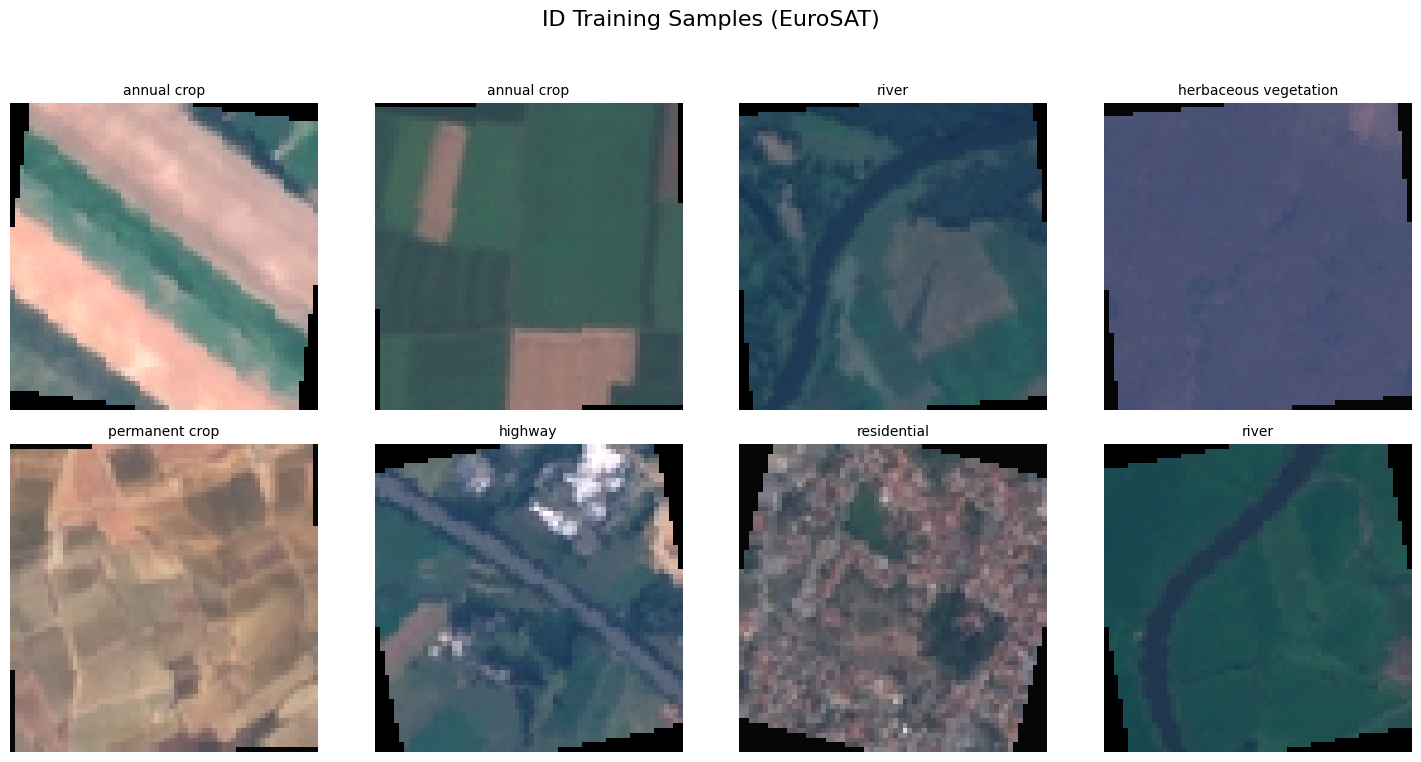

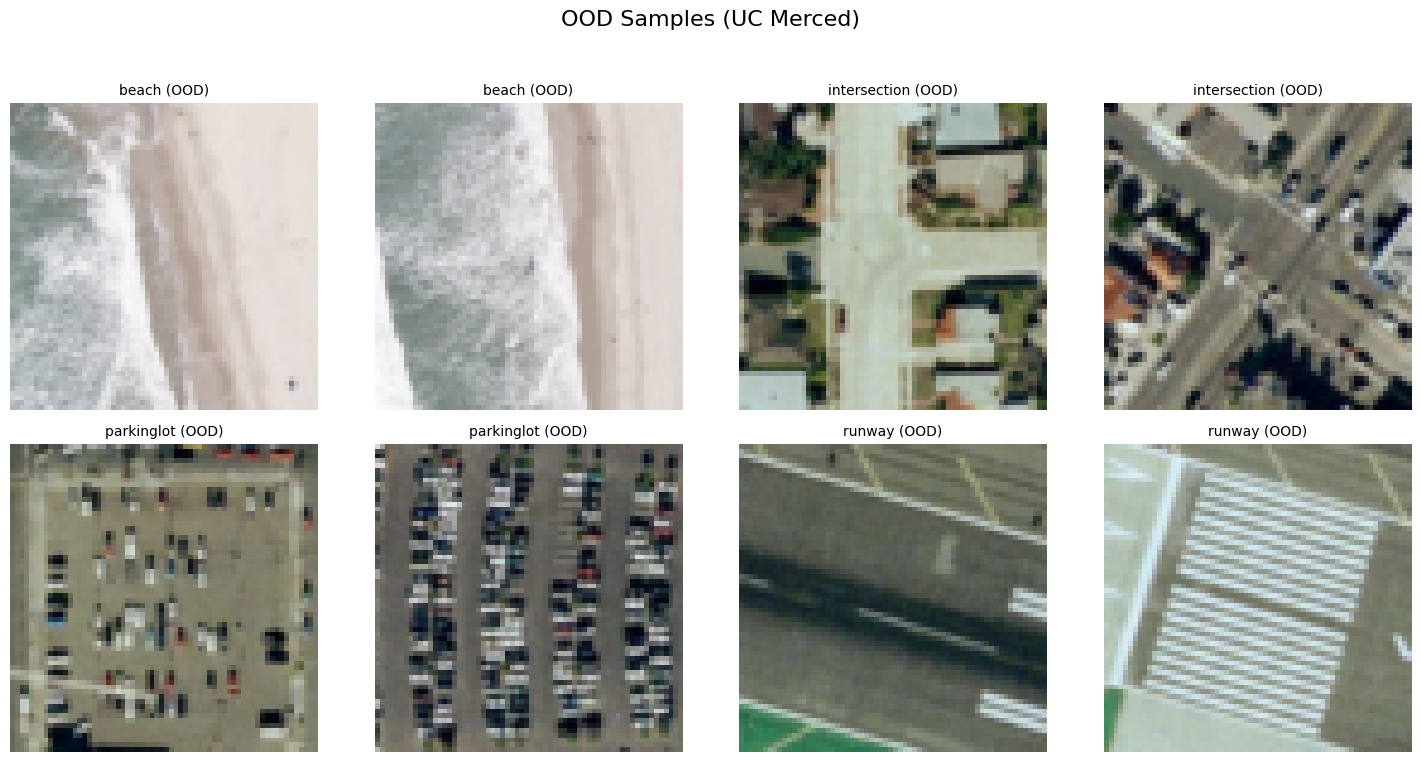

In [12]:
def denormalize(tensor):
    """Denormalize image tensor for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def visualize_samples_diverse(loader, title, class_names, num_samples=8, is_ood_loader=False, ood_label_to_name=None):
    """Visualize sample images from dataloader, ensuring diversity in OOD classes."""
    
    if is_ood_loader and ood_label_to_name is not None:
        # For OOD loader, collect samples from different classes
        collected_samples = {label: [] for label in ood_label_to_name.keys()}
        
        # Iterate through the loader to collect samples from each class
        for images, labels in loader:
            for img, lbl in zip(images, labels):
                label_idx = lbl.item()
                if label_idx in collected_samples and len(collected_samples[label_idx]) < 2:
                    collected_samples[label_idx].append((img, label_idx))
            
            # Check if we have enough samples
            if all(len(samples) >= 2 for samples in collected_samples.values()):
                break
        
        # Flatten collected samples
        all_samples = []
        for label_idx in sorted(collected_samples.keys()):
            all_samples.extend(collected_samples[label_idx][:2])
        
        # Limit to num_samples
        all_samples = all_samples[:num_samples]
        
        if len(all_samples) == 0:
            print(f"No data in {title} loader.")
            return
        
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        fig.suptitle(title, fontsize=16)
        
        for i, ax in enumerate(axes.flat):
            if i >= len(all_samples):
                ax.axis('off')
                continue
            
            img, label_idx = all_samples[i]
            img = denormalize(img).numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            
            if label_idx in ood_label_to_name:
                title_text = f"{ood_label_to_name[label_idx]} (OOD)"
            else:
                title_text = f"Unknown OOD (UC Merced Label: {label_idx})"
            
            ax.set_title(title_text, fontsize=10, ha='center')
            ax.axis('off')
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
    else:
        # For ID loader, use original logic
        try:
            images, labels = next(iter(loader))
        except StopIteration:
            print(f"No data in {title} loader.")
            return

        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        fig.suptitle(title, fontsize=16)

        for i, ax in enumerate(axes.flat):
            if i >= len(images) or i >= num_samples:
                ax.axis('off')
                continue

            img = denormalize(images[i]).numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            label_idx = labels[i].item()

            if label_idx >= 0 and label_idx < len(class_names):
                title_text = f"{class_names[label_idx]}"
            else:
                title_text = f"Label: {label_idx}"

            ax.set_title(title_text, fontsize=10, ha='center')
            ax.axis('off')

        plt.tight_layout(pad=3.0)
        plt.show()

# Create mapping from UC Merced original labels to OOD class names
ood_label_to_name_map = {ood_label_map[name]: name for name in OOD_CLASS_NAMES}

visualize_samples_diverse(train_loader, "ID Training Samples (EuroSAT)", ID_CLASS_NAMES)
visualize_samples_diverse(ood_loader, "OOD Samples (UC Merced)", OOD_CLASS_NAMES, 
                 is_ood_loader=True, ood_label_to_name=ood_label_to_name_map)

### 3.3. Supervised Fine-tuning with Pretrained Encoder

In [13]:
# Use the encoder initialized in the previous section (no pretrained weights)

print("="*80)
print("🎯 CREATING SUPERVISED MODEL (TRAINING FROM SCRATCH)")
print("="*80)
print("Using randomly initialized encoder (no pretraining)")
print()

# Create supervised model with fresh encoder
supervised_model = SupervisedModel(
    encoder=encoder,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
).to(device)

# Count parameters
total_params = sum(p.numel() for p in supervised_model.parameters())
encoder_params = sum(p.numel() for p in supervised_model.encoder.parameters())
classifier_params = sum(p.numel() for p in supervised_model.classifier.parameters())

print(f"✓ Supervised model created with random initialization")
print(f"  Total parameters: {total_params:,}")
print(f"  Encoder (random init): {encoder_params:,}")
print(f"  Classifier (random init): {classifier_params:,}")

# ==========================================
# NO PROGRESSIVE UNFREEZING - TRAIN ALL LAYERS FROM START
# ==========================================
print("\n" + "="*80)
print("🔓 ALL LAYERS TRAINABLE FROM THE START")
print("="*80)

# All encoder layers are trainable (no freezing needed for training from scratch)
trainable_params = sum(p.numel() for p in supervised_model.parameters() if p.requires_grad)
print(f"✓ All layers trainable")
print(f"  Trainable parameters: {trainable_params:,}")
print("\nNote: No progressive unfreezing needed when training from scratch")
print("="*80)

🎯 CREATING SUPERVISED MODEL (TRAINING FROM SCRATCH)
Using randomly initialized encoder (no pretraining)

✓ Supervised model created with random initialization
  Total parameters: 1,412,682
  Encoder (random init): 1,147,200
  Classifier (random init): 265,482

🔓 ALL LAYERS TRAINABLE FROM THE START
✓ All layers trainable
  Trainable parameters: 1,412,682

Note: No progressive unfreezing needed when training from scratch


In [14]:
# ==========================================
# Simplified Training Setup (No Progressive Unfreezing)
# ==========================================
# Since we're training from scratch, we don't need progressive unfreezing
# All layers will be trainable from the beginning

print("✓ Training from scratch - no progressive unfreezing needed")
print("  All layers will be trained simultaneously")
print("  Using standard Adam optimizer with single learning rate")

✓ Training from scratch - no progressive unfreezing needed
  All layers will be trained simultaneously
  Using standard Adam optimizer with single learning rate


In [15]:
# Display trainable parameters summary for each phase
print("\n" + "="*80)
print("📊 TRAINABLE PARAMETERS SUMMARY BY PHASE")
print("="*80)

def count_trainable_params(model):
    """Count trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layer_params(layer):
    """Count parameters in a specific layer."""
    return sum(p.numel() for p in layer.parameters())

# Total parameters
total = count_layer_params(supervised_model)
conv1_params = count_layer_params(supervised_model.encoder.conv1)
conv2_params = count_layer_params(supervised_model.encoder.conv2)
conv3_params = count_layer_params(supervised_model.encoder.conv3)
classifier_params = count_layer_params(supervised_model.classifier)

print(f"\nTotal Model Parameters: {total:,}")
print(f"  Conv1 (bottom): {conv1_params:,}")
print(f"  Conv2 (middle): {conv2_params:,}")
print(f"  Conv3 (top):    {conv3_params:,}")
print(f"  Classifier:     {classifier_params:,}")

# Trainable parameters by phase
print(f"\n{'Phase':<20} {'Trainable Params':<20} {'% of Total':<15} {'Trainable Layers'}")
print("-" * 80)

phase_info = [
    ("Phase 1 (0-50)", classifier_params, "Classifier"),
    ("Phase 2 (51-100)", classifier_params + conv3_params, "Classifier + Conv3"),
    ("Phase 3 (101-150)", classifier_params + conv3_params + conv2_params, "Classifier + Conv3 + Conv2"),
    ("Phase 4 (151-200)", total, "All layers")
]

for phase_name, trainable, layers in phase_info:
    percentage = (trainable / total) * 100
    print(f"{phase_name:<20} {trainable:>15,}   {percentage:>6.2f}%        {layers}")

print("="*80)


📊 TRAINABLE PARAMETERS SUMMARY BY PHASE

Total Model Parameters: 1,412,682
  Conv1 (bottom): 38,976
  Conv2 (middle): 221,952
  Conv3 (top):    886,272
  Classifier:     265,482

Phase                Trainable Params     % of Total      Trainable Layers
--------------------------------------------------------------------------------
Phase 1 (0-50)               265,482    18.79%        Classifier
Phase 2 (51-100)           1,151,754    81.53%        Classifier + Conv3
Phase 3 (101-150)          1,373,706    97.24%        Classifier + Conv3 + Conv2
Phase 4 (151-200)          1,412,682   100.00%        All layers


In [16]:
# ==========================================
# Training and Validation Functions
# ==========================================

def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    """
    Train for one epoch with mixed precision support.
    
    Args:
        model: The model to train
        dataloader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use
        scaler: GradScaler for mixed precision (optional)
    
    Returns:
        avg_loss: Average loss for the epoch
        avg_acc: Average accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            # Mixed precision training
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / total
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc


def validate(model, dataloader, criterion, device):
    """
    Validate the model.
    
    Args:
        model: The model to validate
        dataloader: Validation data loader
        criterion: Loss function
        device: Device to use
    
    Returns:
        avg_loss: Average loss
        avg_acc: Average accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / total
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc


print("✓ Training and validation functions defined")
print("  - train_epoch(): Trains model for one epoch with mixed precision")
print("  - validate(): Evaluates model on validation set")

✓ Training and validation functions defined
  - train_epoch(): Trains model for one epoch with mixed precision
  - validate(): Evaluates model on validation set


In [17]:
# ==========================================
# Supervised Training Loop (From Scratch)
# ==========================================

print("="*80)
print("🎯 STARTING SUPERVISED TRAINING FROM SCRATCH")
print("="*80)
print(f"Training epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Dropout rate: {DROPOUT_RATE}")
print("="*80)

# Initialize optimizer and scheduler
optimizer = optim.Adam(supervised_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()

# Scaler for mixed precision training (updated to avoid deprecation warning)
supervised_scaler = torch.amp.GradScaler('cuda')

# Training history
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

# Training loop
for epoch in range(NUM_EPOCHS):
    # ==========================================
    # Training & Validation
    # ==========================================
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    train_loss, train_acc = train_epoch(
        supervised_model, train_loader, criterion, optimizer, device, scaler=supervised_scaler
    )
    val_loss, val_acc = validate(supervised_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': supervised_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_supervised_model_no_pretrain.pth')
        print(f"✓ Saved best model with validation accuracy: {val_acc:.2f}%")

# Save training history
import pickle
history = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'best_val_acc': best_val_acc
}
with open('training_history_scratch.pkl', 'wb') as f:
    pickle.dump(history, f)
print(f"\n✓ Training history saved to 'training_history_scratch.pkl'")

print(f"\n{'='*60}")
print(f"SUPERVISED TRAINING COMPLETE!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}")
print("\nModel trained from scratch (no pretrained weights)")
print(f"All layers trained simultaneously for {NUM_EPOCHS} epochs")
print(f"{'='*60}")

🎯 STARTING SUPERVISED TRAINING FROM SCRATCH
Training epochs: 200
Learning rate: 0.001
Batch size: 1024
Dropout rate: 0.1

Epoch 1/200



Train Loss: 1.4764 | Train Acc: 48.10%
Val Loss: 2.8479 | Val Acc: 30.57%
✓ Saved best model with validation accuracy: 30.57%

Epoch 2/200



Train Loss: 0.9284 | Train Acc: 66.28%
Val Loss: 1.1416 | Val Acc: 63.48%
✓ Saved best model with validation accuracy: 63.48%

Epoch 3/200



Train Loss: 0.8158 | Train Acc: 70.87%
Val Loss: 1.0050 | Val Acc: 65.24%
✓ Saved best model with validation accuracy: 65.24%

Epoch 4/200



Train Loss: 0.7134 | Train Acc: 74.13%
Val Loss: 0.7557 | Val Acc: 73.07%
✓ Saved best model with validation accuracy: 73.07%

Epoch 5/200



Train Loss: 0.6343 | Train Acc: 77.19%
Val Loss: 0.5214 | Val Acc: 81.44%
✓ Saved best model with validation accuracy: 81.44%

Epoch 6/200



Train Loss: 0.5828 | Train Acc: 79.29%
Val Loss: 0.5211 | Val Acc: 80.63%

Epoch 7/200



Train Loss: 0.5604 | Train Acc: 80.21%
Val Loss: 0.5264 | Val Acc: 82.20%
✓ Saved best model with validation accuracy: 82.20%

Epoch 8/200



Train Loss: 0.5154 | Train Acc: 81.99%
Val Loss: 0.4063 | Val Acc: 85.94%
✓ Saved best model with validation accuracy: 85.94%

Epoch 9/200



Train Loss: 0.4937 | Train Acc: 82.82%
Val Loss: 0.4002 | Val Acc: 86.00%
✓ Saved best model with validation accuracy: 86.00%

Epoch 10/200



Train Loss: 0.4753 | Train Acc: 83.27%
Val Loss: 0.3523 | Val Acc: 87.93%
✓ Saved best model with validation accuracy: 87.93%

Epoch 11/200



Train Loss: 0.4107 | Train Acc: 85.75%
Val Loss: 0.3800 | Val Acc: 87.19%

Epoch 12/200



Train Loss: 0.4016 | Train Acc: 86.15%
Val Loss: 0.2885 | Val Acc: 89.96%
✓ Saved best model with validation accuracy: 89.96%

Epoch 13/200



Train Loss: 0.3744 | Train Acc: 86.82%
Val Loss: 0.2717 | Val Acc: 90.63%
✓ Saved best model with validation accuracy: 90.63%

Epoch 14/200



Train Loss: 0.3728 | Train Acc: 87.26%
Val Loss: 0.3575 | Val Acc: 87.72%

Epoch 15/200



Train Loss: 0.3483 | Train Acc: 88.05%
Val Loss: 0.3265 | Val Acc: 88.85%

Epoch 16/200



Train Loss: 0.3434 | Train Acc: 88.03%
Val Loss: 0.2352 | Val Acc: 91.87%
✓ Saved best model with validation accuracy: 91.87%

Epoch 17/200



Train Loss: 0.3128 | Train Acc: 89.27%
Val Loss: 0.2542 | Val Acc: 91.13%

Epoch 18/200



Train Loss: 0.2929 | Train Acc: 90.01%
Val Loss: 0.2011 | Val Acc: 92.91%
✓ Saved best model with validation accuracy: 92.91%

Epoch 19/200



Train Loss: 0.2790 | Train Acc: 90.79%
Val Loss: 0.1972 | Val Acc: 93.24%
✓ Saved best model with validation accuracy: 93.24%

Epoch 20/200



Train Loss: 0.2660 | Train Acc: 90.83%
Val Loss: 0.2970 | Val Acc: 89.87%

Epoch 21/200



Train Loss: 0.2678 | Train Acc: 90.70%
Val Loss: 0.1963 | Val Acc: 92.89%

Epoch 22/200



Train Loss: 0.2623 | Train Acc: 91.06%
Val Loss: 0.2520 | Val Acc: 91.20%

Epoch 23/200



Train Loss: 0.2655 | Train Acc: 91.00%
Val Loss: 0.1674 | Val Acc: 94.09%
✓ Saved best model with validation accuracy: 94.09%

Epoch 24/200



Train Loss: 0.2525 | Train Acc: 91.11%
Val Loss: 0.2559 | Val Acc: 90.57%

Epoch 25/200



Train Loss: 0.2484 | Train Acc: 91.26%
Val Loss: 0.1694 | Val Acc: 94.04%

Epoch 26/200



Train Loss: 0.2360 | Train Acc: 91.83%
Val Loss: 0.1770 | Val Acc: 94.04%

Epoch 27/200



Train Loss: 0.2369 | Train Acc: 91.93%
Val Loss: 0.1493 | Val Acc: 94.67%
✓ Saved best model with validation accuracy: 94.67%

Epoch 28/200



Train Loss: 0.2310 | Train Acc: 92.16%
Val Loss: 0.1573 | Val Acc: 94.76%
✓ Saved best model with validation accuracy: 94.76%

Epoch 29/200



Train Loss: 0.2161 | Train Acc: 92.46%
Val Loss: 0.1797 | Val Acc: 93.83%

Epoch 30/200



Train Loss: 0.2011 | Train Acc: 93.19%
Val Loss: 0.1791 | Val Acc: 94.13%

Epoch 31/200



Train Loss: 0.2108 | Train Acc: 92.73%
Val Loss: 0.1406 | Val Acc: 95.33%
✓ Saved best model with validation accuracy: 95.33%

Epoch 32/200



Train Loss: 0.2065 | Train Acc: 92.92%
Val Loss: 0.1489 | Val Acc: 94.78%

Epoch 33/200



Train Loss: 0.1979 | Train Acc: 93.17%
Val Loss: 0.1567 | Val Acc: 94.91%

Epoch 34/200



Train Loss: 0.2026 | Train Acc: 93.14%
Val Loss: 0.1205 | Val Acc: 95.87%
✓ Saved best model with validation accuracy: 95.87%

Epoch 35/200



Train Loss: 0.1965 | Train Acc: 93.05%
Val Loss: 0.1408 | Val Acc: 95.30%

Epoch 36/200



Train Loss: 0.1880 | Train Acc: 93.35%
Val Loss: 0.1547 | Val Acc: 94.76%

Epoch 37/200



Train Loss: 0.1721 | Train Acc: 94.02%
Val Loss: 0.1426 | Val Acc: 95.04%

Epoch 38/200



Train Loss: 0.1844 | Train Acc: 93.58%
Val Loss: 0.1373 | Val Acc: 95.28%

Epoch 39/200



Train Loss: 0.1805 | Train Acc: 93.71%
Val Loss: 0.1200 | Val Acc: 95.87%

Epoch 40/200



Train Loss: 0.1760 | Train Acc: 93.93%
Val Loss: 0.1159 | Val Acc: 96.11%
✓ Saved best model with validation accuracy: 96.11%

Epoch 41/200



Train Loss: 0.1673 | Train Acc: 94.09%
Val Loss: 0.1486 | Val Acc: 94.83%

Epoch 42/200



Train Loss: 0.1743 | Train Acc: 93.92%
Val Loss: 0.1080 | Val Acc: 96.17%
✓ Saved best model with validation accuracy: 96.17%

Epoch 43/200



Train Loss: 0.1561 | Train Acc: 94.60%
Val Loss: 0.1337 | Val Acc: 95.52%

Epoch 44/200



Train Loss: 0.1628 | Train Acc: 94.44%
Val Loss: 0.1227 | Val Acc: 95.80%

Epoch 45/200



Train Loss: 0.1670 | Train Acc: 94.21%
Val Loss: 0.1157 | Val Acc: 95.80%

Epoch 46/200



Train Loss: 0.1608 | Train Acc: 94.57%
Val Loss: 0.1006 | Val Acc: 96.50%
✓ Saved best model with validation accuracy: 96.50%

Epoch 47/200



Train Loss: 0.1568 | Train Acc: 94.62%
Val Loss: 0.1136 | Val Acc: 95.91%

Epoch 48/200



Train Loss: 0.1562 | Train Acc: 94.51%
Val Loss: 0.1201 | Val Acc: 96.02%

Epoch 49/200



Train Loss: 0.1632 | Train Acc: 94.31%
Val Loss: 0.1108 | Val Acc: 96.19%

Epoch 50/200



Train Loss: 0.1390 | Train Acc: 95.18%
Val Loss: 0.1179 | Val Acc: 96.11%

Epoch 51/200



Train Loss: 0.1487 | Train Acc: 94.94%
Val Loss: 0.1253 | Val Acc: 95.57%

Epoch 52/200



Train Loss: 0.1439 | Train Acc: 95.08%
Val Loss: 0.1196 | Val Acc: 95.67%

Epoch 53/200



Train Loss: 0.1286 | Train Acc: 95.65%
Val Loss: 0.0911 | Val Acc: 96.89%
✓ Saved best model with validation accuracy: 96.89%

Epoch 54/200



Train Loss: 0.1208 | Train Acc: 95.75%
Val Loss: 0.0839 | Val Acc: 97.19%
✓ Saved best model with validation accuracy: 97.19%

Epoch 55/200



Train Loss: 0.1187 | Train Acc: 95.87%
Val Loss: 0.0807 | Val Acc: 97.11%

Epoch 56/200



Train Loss: 0.1142 | Train Acc: 95.92%
Val Loss: 0.0802 | Val Acc: 97.35%
✓ Saved best model with validation accuracy: 97.35%

Epoch 57/200



Train Loss: 0.1212 | Train Acc: 95.70%
Val Loss: 0.0826 | Val Acc: 97.33%

Epoch 58/200



Train Loss: 0.1075 | Train Acc: 96.21%
Val Loss: 0.0817 | Val Acc: 97.09%

Epoch 59/200



Train Loss: 0.1136 | Train Acc: 95.99%
Val Loss: 0.0903 | Val Acc: 96.94%

Epoch 60/200



Train Loss: 0.1150 | Train Acc: 96.01%
Val Loss: 0.0826 | Val Acc: 96.96%

Epoch 61/200



Train Loss: 0.1136 | Train Acc: 96.02%
Val Loss: 0.0798 | Val Acc: 97.52%
✓ Saved best model with validation accuracy: 97.52%

Epoch 62/200



Train Loss: 0.1122 | Train Acc: 96.15%
Val Loss: 0.0807 | Val Acc: 97.15%

Epoch 63/200



Train Loss: 0.1055 | Train Acc: 96.15%
Val Loss: 0.0744 | Val Acc: 97.50%

Epoch 64/200



Train Loss: 0.1079 | Train Acc: 96.32%
Val Loss: 0.0777 | Val Acc: 97.33%

Epoch 65/200



Train Loss: 0.1084 | Train Acc: 96.17%
Val Loss: 0.0828 | Val Acc: 97.22%

Epoch 66/200



Train Loss: 0.1022 | Train Acc: 96.41%
Val Loss: 0.0875 | Val Acc: 97.11%

Epoch 67/200



Train Loss: 0.1140 | Train Acc: 96.08%
Val Loss: 0.0822 | Val Acc: 97.39%

Epoch 68/200



Train Loss: 0.1069 | Train Acc: 96.19%
Val Loss: 0.0912 | Val Acc: 96.81%

Epoch 69/200



Train Loss: 0.1073 | Train Acc: 96.31%
Val Loss: 0.0754 | Val Acc: 97.67%
✓ Saved best model with validation accuracy: 97.67%

Epoch 70/200



Train Loss: 0.0965 | Train Acc: 96.65%
Val Loss: 0.0722 | Val Acc: 97.67%

Epoch 71/200



Train Loss: 0.0961 | Train Acc: 96.52%
Val Loss: 0.0721 | Val Acc: 97.65%

Epoch 72/200



Train Loss: 0.0900 | Train Acc: 96.84%
Val Loss: 0.0766 | Val Acc: 97.48%

Epoch 73/200



Train Loss: 0.0886 | Train Acc: 96.82%
Val Loss: 0.0703 | Val Acc: 97.57%

Epoch 74/200



Train Loss: 0.0900 | Train Acc: 96.78%
Val Loss: 0.0690 | Val Acc: 97.83%
✓ Saved best model with validation accuracy: 97.83%

Epoch 75/200



Train Loss: 0.0932 | Train Acc: 96.72%
Val Loss: 0.0842 | Val Acc: 97.20%

Epoch 76/200



Train Loss: 0.0955 | Train Acc: 96.68%
Val Loss: 0.0696 | Val Acc: 97.81%

Epoch 77/200



Train Loss: 0.0871 | Train Acc: 97.01%
Val Loss: 0.0735 | Val Acc: 97.54%

Epoch 78/200



Train Loss: 0.0903 | Train Acc: 96.82%
Val Loss: 0.0686 | Val Acc: 97.61%

Epoch 79/200



Train Loss: 0.0869 | Train Acc: 96.84%
Val Loss: 0.0693 | Val Acc: 97.59%

Epoch 80/200



Train Loss: 0.0886 | Train Acc: 96.90%
Val Loss: 0.0670 | Val Acc: 97.63%

Epoch 81/200



Train Loss: 0.0867 | Train Acc: 96.98%
Val Loss: 0.0726 | Val Acc: 97.63%

Epoch 82/200



Train Loss: 0.0927 | Train Acc: 96.72%
Val Loss: 0.0683 | Val Acc: 97.74%

Epoch 83/200



Train Loss: 0.0876 | Train Acc: 96.83%
Val Loss: 0.0707 | Val Acc: 97.72%

Epoch 84/200



Train Loss: 0.0816 | Train Acc: 97.15%
Val Loss: 0.0714 | Val Acc: 97.63%

Epoch 85/200



Train Loss: 0.0859 | Train Acc: 97.02%
Val Loss: 0.0673 | Val Acc: 97.81%

Epoch 86/200



Train Loss: 0.0860 | Train Acc: 96.94%
Val Loss: 0.0704 | Val Acc: 97.50%

Epoch 87/200



Train Loss: 0.0806 | Train Acc: 97.17%
Val Loss: 0.0638 | Val Acc: 97.85%
✓ Saved best model with validation accuracy: 97.85%

Epoch 88/200



Train Loss: 0.0814 | Train Acc: 97.18%
Val Loss: 0.0653 | Val Acc: 97.85%

Epoch 89/200



Train Loss: 0.0815 | Train Acc: 97.01%
Val Loss: 0.0641 | Val Acc: 97.93%
✓ Saved best model with validation accuracy: 97.93%

Epoch 90/200



Train Loss: 0.0759 | Train Acc: 97.40%
Val Loss: 0.0653 | Val Acc: 97.91%

Epoch 91/200



Train Loss: 0.0781 | Train Acc: 97.23%
Val Loss: 0.0622 | Val Acc: 97.98%
✓ Saved best model with validation accuracy: 97.98%

Epoch 92/200



Train Loss: 0.0796 | Train Acc: 97.22%
Val Loss: 0.0655 | Val Acc: 97.87%

Epoch 93/200



Train Loss: 0.0796 | Train Acc: 97.15%
Val Loss: 0.0640 | Val Acc: 97.93%

Epoch 94/200



Train Loss: 0.0763 | Train Acc: 97.31%
Val Loss: 0.0635 | Val Acc: 97.94%

Epoch 95/200



Train Loss: 0.0818 | Train Acc: 97.10%
Val Loss: 0.0631 | Val Acc: 97.96%

Epoch 96/200



Train Loss: 0.0842 | Train Acc: 97.06%
Val Loss: 0.0655 | Val Acc: 97.85%

Epoch 97/200



Train Loss: 0.0747 | Train Acc: 97.31%
Val Loss: 0.0621 | Val Acc: 97.87%

Epoch 98/200



Train Loss: 0.0748 | Train Acc: 97.33%
Val Loss: 0.0619 | Val Acc: 98.13%
✓ Saved best model with validation accuracy: 98.13%

Epoch 99/200



Train Loss: 0.0764 | Train Acc: 97.27%
Val Loss: 0.0632 | Val Acc: 98.04%

Epoch 100/200



Train Loss: 0.0727 | Train Acc: 97.49%
Val Loss: 0.0614 | Val Acc: 97.94%

Epoch 101/200



Train Loss: 0.0764 | Train Acc: 97.19%
Val Loss: 0.0632 | Val Acc: 97.93%

Epoch 102/200



Train Loss: 0.0761 | Train Acc: 97.21%
Val Loss: 0.0654 | Val Acc: 97.85%

Epoch 103/200



Train Loss: 0.0786 | Train Acc: 97.21%
Val Loss: 0.0676 | Val Acc: 97.85%

Epoch 104/200



Train Loss: 0.0779 | Train Acc: 97.22%
Val Loss: 0.0644 | Val Acc: 97.89%

Epoch 105/200



Train Loss: 0.0793 | Train Acc: 97.17%
Val Loss: 0.0628 | Val Acc: 97.85%

Epoch 106/200



Train Loss: 0.0749 | Train Acc: 97.33%
Val Loss: 0.0624 | Val Acc: 97.81%

Epoch 107/200



Train Loss: 0.0744 | Train Acc: 97.39%
Val Loss: 0.0634 | Val Acc: 97.91%

Epoch 108/200



Train Loss: 0.0704 | Train Acc: 97.53%
Val Loss: 0.0612 | Val Acc: 98.02%

Epoch 109/200



Train Loss: 0.0714 | Train Acc: 97.48%
Val Loss: 0.0631 | Val Acc: 98.06%

Epoch 110/200



Train Loss: 0.0722 | Train Acc: 97.40%
Val Loss: 0.0643 | Val Acc: 97.93%

Epoch 111/200



Train Loss: 0.0723 | Train Acc: 97.36%
Val Loss: 0.0630 | Val Acc: 97.87%

Epoch 112/200



Train Loss: 0.0717 | Train Acc: 97.47%
Val Loss: 0.0639 | Val Acc: 98.02%

Epoch 113/200



Train Loss: 0.0716 | Train Acc: 97.47%
Val Loss: 0.0622 | Val Acc: 98.00%

Epoch 114/200



Train Loss: 0.0698 | Train Acc: 97.52%
Val Loss: 0.0642 | Val Acc: 98.06%

Epoch 115/200



Train Loss: 0.0692 | Train Acc: 97.53%
Val Loss: 0.0609 | Val Acc: 98.00%

Epoch 116/200



Train Loss: 0.0675 | Train Acc: 97.67%
Val Loss: 0.0620 | Val Acc: 98.02%

Epoch 117/200



Train Loss: 0.0669 | Train Acc: 97.72%
Val Loss: 0.0603 | Val Acc: 98.04%

Epoch 118/200



Train Loss: 0.0659 | Train Acc: 97.71%
Val Loss: 0.0601 | Val Acc: 98.09%

Epoch 119/200



Train Loss: 0.0653 | Train Acc: 97.81%
Val Loss: 0.0603 | Val Acc: 98.09%

Epoch 120/200



Train Loss: 0.0634 | Train Acc: 97.77%
Val Loss: 0.0608 | Val Acc: 98.00%

Epoch 121/200



Train Loss: 0.0663 | Train Acc: 97.73%
Val Loss: 0.0617 | Val Acc: 98.04%

Epoch 122/200



Train Loss: 0.0657 | Train Acc: 97.73%
Val Loss: 0.0611 | Val Acc: 98.13%

Epoch 123/200



Train Loss: 0.0666 | Train Acc: 97.62%
Val Loss: 0.0616 | Val Acc: 98.00%

Epoch 124/200



Train Loss: 0.0668 | Train Acc: 97.66%
Val Loss: 0.0620 | Val Acc: 98.11%

Epoch 125/200



Train Loss: 0.0659 | Train Acc: 97.63%
Val Loss: 0.0605 | Val Acc: 98.04%

Epoch 126/200



Train Loss: 0.0668 | Train Acc: 97.61%
Val Loss: 0.0610 | Val Acc: 98.00%

Epoch 127/200



Train Loss: 0.0656 | Train Acc: 97.67%
Val Loss: 0.0599 | Val Acc: 98.00%

Epoch 128/200



Train Loss: 0.0659 | Train Acc: 97.77%
Val Loss: 0.0597 | Val Acc: 98.06%

Epoch 129/200



Train Loss: 0.0662 | Train Acc: 97.69%
Val Loss: 0.0593 | Val Acc: 97.98%

Epoch 130/200



Train Loss: 0.0695 | Train Acc: 97.47%
Val Loss: 0.0613 | Val Acc: 98.00%

Epoch 131/200



Train Loss: 0.0639 | Train Acc: 97.75%
Val Loss: 0.0602 | Val Acc: 98.02%

Epoch 132/200



Train Loss: 0.0670 | Train Acc: 97.56%
Val Loss: 0.0601 | Val Acc: 98.02%

Epoch 133/200



Train Loss: 0.0683 | Train Acc: 97.62%
Val Loss: 0.0599 | Val Acc: 98.11%

Epoch 134/200



Train Loss: 0.0632 | Train Acc: 97.76%
Val Loss: 0.0601 | Val Acc: 98.07%

Epoch 135/200



Train Loss: 0.0635 | Train Acc: 97.82%
Val Loss: 0.0609 | Val Acc: 98.04%

Epoch 136/200



Train Loss: 0.0673 | Train Acc: 97.64%
Val Loss: 0.0603 | Val Acc: 98.00%

Epoch 137/200



Train Loss: 0.0635 | Train Acc: 97.80%
Val Loss: 0.0604 | Val Acc: 98.02%

Epoch 138/200



Train Loss: 0.0655 | Train Acc: 97.52%
Val Loss: 0.0601 | Val Acc: 98.06%

Epoch 139/200



Train Loss: 0.0650 | Train Acc: 97.69%
Val Loss: 0.0599 | Val Acc: 98.07%

Epoch 140/200



Train Loss: 0.0661 | Train Acc: 97.69%
Val Loss: 0.0604 | Val Acc: 98.07%

Epoch 141/200



Train Loss: 0.0663 | Train Acc: 97.62%
Val Loss: 0.0602 | Val Acc: 98.07%

Epoch 142/200



Train Loss: 0.0669 | Train Acc: 97.69%
Val Loss: 0.0612 | Val Acc: 98.02%

Epoch 143/200



Train Loss: 0.0672 | Train Acc: 97.62%
Val Loss: 0.0607 | Val Acc: 98.02%

Epoch 144/200



Train Loss: 0.0613 | Train Acc: 97.81%
Val Loss: 0.0601 | Val Acc: 98.02%

Epoch 145/200



Train Loss: 0.0662 | Train Acc: 97.57%
Val Loss: 0.0600 | Val Acc: 98.07%

Epoch 146/200



Train Loss: 0.0673 | Train Acc: 97.64%
Val Loss: 0.0598 | Val Acc: 98.07%

Epoch 147/200



Train Loss: 0.0657 | Train Acc: 97.67%
Val Loss: 0.0599 | Val Acc: 98.09%

Epoch 148/200



Train Loss: 0.0673 | Train Acc: 97.69%
Val Loss: 0.0599 | Val Acc: 98.00%

Epoch 149/200



Train Loss: 0.0658 | Train Acc: 97.69%
Val Loss: 0.0599 | Val Acc: 98.04%

Epoch 150/200



Train Loss: 0.0637 | Train Acc: 97.71%
Val Loss: 0.0601 | Val Acc: 98.07%

Epoch 151/200



Train Loss: 0.0668 | Train Acc: 97.67%
Val Loss: 0.0597 | Val Acc: 98.06%

Epoch 152/200



Train Loss: 0.0664 | Train Acc: 97.73%
Val Loss: 0.0596 | Val Acc: 98.09%

Epoch 153/200



Train Loss: 0.0644 | Train Acc: 97.71%
Val Loss: 0.0596 | Val Acc: 98.06%

Epoch 154/200



Train Loss: 0.0651 | Train Acc: 97.66%
Val Loss: 0.0600 | Val Acc: 98.06%

Epoch 155/200



Train Loss: 0.0642 | Train Acc: 97.81%
Val Loss: 0.0606 | Val Acc: 98.02%

Epoch 156/200



Train Loss: 0.0651 | Train Acc: 97.68%
Val Loss: 0.0600 | Val Acc: 98.07%

Epoch 157/200



Train Loss: 0.0631 | Train Acc: 97.75%
Val Loss: 0.0594 | Val Acc: 98.06%

Epoch 158/200



Train Loss: 0.0657 | Train Acc: 97.67%
Val Loss: 0.0601 | Val Acc: 98.04%

Epoch 159/200



Train Loss: 0.0648 | Train Acc: 97.70%
Val Loss: 0.0603 | Val Acc: 98.04%

Epoch 160/200



Train Loss: 0.0658 | Train Acc: 97.72%
Val Loss: 0.0600 | Val Acc: 98.09%

Epoch 161/200



Train Loss: 0.0669 | Train Acc: 97.63%
Val Loss: 0.0597 | Val Acc: 98.04%

Epoch 162/200



Train Loss: 0.0647 | Train Acc: 97.83%
Val Loss: 0.0602 | Val Acc: 98.04%

Epoch 163/200



Train Loss: 0.0665 | Train Acc: 97.66%
Val Loss: 0.0598 | Val Acc: 98.11%

Epoch 164/200



Train Loss: 0.0649 | Train Acc: 97.75%
Val Loss: 0.0601 | Val Acc: 98.07%

Epoch 165/200



Train Loss: 0.0657 | Train Acc: 97.80%
Val Loss: 0.0600 | Val Acc: 98.07%

Epoch 166/200



Train Loss: 0.0634 | Train Acc: 97.85%
Val Loss: 0.0604 | Val Acc: 98.04%

Epoch 167/200



Train Loss: 0.0645 | Train Acc: 97.73%
Val Loss: 0.0604 | Val Acc: 98.07%

Epoch 168/200



Train Loss: 0.0640 | Train Acc: 97.71%
Val Loss: 0.0599 | Val Acc: 98.07%

Epoch 169/200



Train Loss: 0.0661 | Train Acc: 97.68%
Val Loss: 0.0603 | Val Acc: 98.04%

Epoch 170/200



Train Loss: 0.0642 | Train Acc: 97.88%
Val Loss: 0.0600 | Val Acc: 98.07%

Epoch 171/200



Train Loss: 0.0656 | Train Acc: 97.62%
Val Loss: 0.0599 | Val Acc: 98.11%

Epoch 172/200



Train Loss: 0.0661 | Train Acc: 97.63%
Val Loss: 0.0604 | Val Acc: 98.06%

Epoch 173/200



Train Loss: 0.0662 | Train Acc: 97.69%
Val Loss: 0.0597 | Val Acc: 98.04%

Epoch 174/200



Train Loss: 0.0658 | Train Acc: 97.72%
Val Loss: 0.0598 | Val Acc: 98.06%

Epoch 175/200



Train Loss: 0.0640 | Train Acc: 97.75%
Val Loss: 0.0603 | Val Acc: 98.07%

Epoch 176/200



Train Loss: 0.0662 | Train Acc: 97.69%
Val Loss: 0.0601 | Val Acc: 98.07%

Epoch 177/200



Train Loss: 0.0643 | Train Acc: 97.82%
Val Loss: 0.0602 | Val Acc: 98.11%

Epoch 178/200



Train Loss: 0.0649 | Train Acc: 97.64%
Val Loss: 0.0604 | Val Acc: 98.06%

Epoch 179/200



Train Loss: 0.0655 | Train Acc: 97.62%
Val Loss: 0.0598 | Val Acc: 98.07%

Epoch 180/200



Train Loss: 0.0641 | Train Acc: 97.77%
Val Loss: 0.0594 | Val Acc: 98.09%

Epoch 181/200



Train Loss: 0.0633 | Train Acc: 97.69%
Val Loss: 0.0602 | Val Acc: 98.04%

Epoch 182/200



Train Loss: 0.0706 | Train Acc: 97.48%
Val Loss: 0.0601 | Val Acc: 98.07%

Epoch 183/200



Train Loss: 0.0673 | Train Acc: 97.65%
Val Loss: 0.0598 | Val Acc: 98.07%

Epoch 184/200



Train Loss: 0.0644 | Train Acc: 97.75%
Val Loss: 0.0601 | Val Acc: 98.06%

Epoch 185/200



Train Loss: 0.0665 | Train Acc: 97.63%
Val Loss: 0.0600 | Val Acc: 98.02%

Epoch 186/200



Train Loss: 0.0641 | Train Acc: 97.68%
Val Loss: 0.0600 | Val Acc: 98.04%

Epoch 187/200



Train Loss: 0.0640 | Train Acc: 97.80%
Val Loss: 0.0602 | Val Acc: 98.07%

Epoch 188/200



Train Loss: 0.0650 | Train Acc: 97.70%
Val Loss: 0.0606 | Val Acc: 98.13%

Epoch 189/200



Train Loss: 0.0658 | Train Acc: 97.68%
Val Loss: 0.0599 | Val Acc: 98.06%

Epoch 190/200



Train Loss: 0.0645 | Train Acc: 97.70%
Val Loss: 0.0598 | Val Acc: 98.09%

Epoch 191/200



Train Loss: 0.0670 | Train Acc: 97.65%
Val Loss: 0.0603 | Val Acc: 98.06%

Epoch 192/200



Train Loss: 0.0681 | Train Acc: 97.52%
Val Loss: 0.0601 | Val Acc: 98.06%

Epoch 193/200



Train Loss: 0.0688 | Train Acc: 97.58%
Val Loss: 0.0603 | Val Acc: 98.07%

Epoch 194/200



Train Loss: 0.0639 | Train Acc: 97.66%
Val Loss: 0.0595 | Val Acc: 98.09%

Epoch 195/200



Train Loss: 0.0633 | Train Acc: 97.68%
Val Loss: 0.0599 | Val Acc: 98.04%

Epoch 196/200



Train Loss: 0.0655 | Train Acc: 97.65%
Val Loss: 0.0609 | Val Acc: 98.06%

Epoch 197/200



Train Loss: 0.0646 | Train Acc: 97.63%
Val Loss: 0.0595 | Val Acc: 98.06%

Epoch 198/200



Train Loss: 0.0671 | Train Acc: 97.66%
Val Loss: 0.0605 | Val Acc: 98.09%

Epoch 199/200



Train Loss: 0.0647 | Train Acc: 97.67%
Val Loss: 0.0598 | Val Acc: 98.11%

Epoch 200/200



Train Loss: 0.0663 | Train Acc: 97.62%
Val Loss: 0.0601 | Val Acc: 98.07%

✓ Training history saved to 'training_history_scratch.pkl'

SUPERVISED TRAINING COMPLETE!
Best validation accuracy: 98.13%

Model trained from scratch (no pretrained weights)
All layers trained simultaneously for 200 epochs


In [18]:
# Training from scratch - no progressive unfreezing visualization needed
print("="*80)
print("📊 TRAINING APPROACH: FROM SCRATCH")
print("="*80)
print("✓ No progressive unfreezing (baseline approach)")
print("✓ All layers trained simultaneously from epoch 0")
print("✓ Standard learning rate for all parameters")
print("="*80)

📊 TRAINING APPROACH: FROM SCRATCH
✓ No progressive unfreezing (baseline approach)
✓ All layers trained simultaneously from epoch 0
✓ Standard learning rate for all parameters


📊 Preparing to plot training curves...
   Train losses: 200 epochs
   Val losses: 200 epochs
   Train accs: 200 epochs
   Val accs: 200 epochs


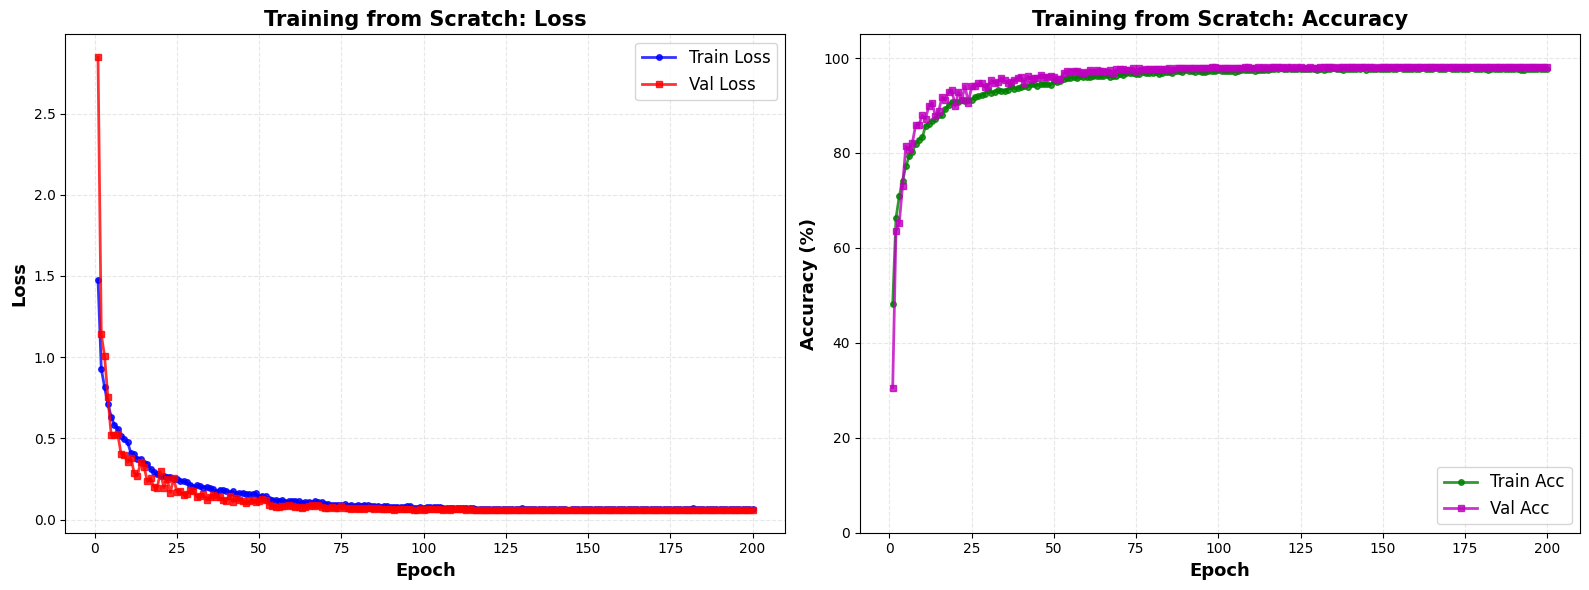


📊 TRAINING STATISTICS
Total Epochs Trained: 200

Final Metrics:
  Train Loss:      0.0663
  Train Accuracy:  97.62%
  Val Loss:        0.0601
  Val Accuracy:    98.07%

Best Performance:
  Best Val Accuracy: 98.13%
  Min Train Loss:    0.0613 (Epoch 144)
  Min Val Loss:      0.0593 (Epoch 129)


In [19]:
# Plot training history
import matplotlib.pyplot as plt
import numpy as np

print(f"📊 Preparing to plot training curves...")
print(f"   Train losses: {len(train_losses)} epochs")
print(f"   Val losses: {len(val_losses)} epochs")
print(f"   Train accs: {len(train_accs)} epochs")
print(f"   Val accs: {len(val_accs)} epochs")

if len(train_losses) > 0:
    # Create figure
    fig = plt.figure(figsize=(16, 6))
    
    # Create epochs array
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Loss subplot
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=4, alpha=0.8)
    ax1.plot(epochs, val_losses, 'r-s', label='Val Loss', linewidth=2, markersize=4, alpha=0.8)
    ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax1.set_title('Training from Scratch: Loss', fontsize=15, fontweight='bold')
    ax1.legend(fontsize=12, loc='upper right')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Accuracy subplot
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, train_accs, 'g-o', label='Train Acc', linewidth=2, markersize=4, alpha=0.8)
    ax2.plot(epochs, val_accs, 'm-s', label='Val Acc', linewidth=2, markersize=4, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax2.set_title('Training from Scratch: Accuracy', fontsize=15, fontweight='bold')
    ax2.legend(fontsize=12, loc='lower right')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim([0, 105])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"📊 TRAINING STATISTICS")
    print(f"{'='*80}")
    print(f"Total Epochs Trained: {len(train_losses)}")
    print(f"\nFinal Metrics:")
    print(f"  Train Loss:      {train_losses[-1]:.4f}")
    print(f"  Train Accuracy:  {train_accs[-1]:.2f}%")
    print(f"  Val Loss:        {val_losses[-1]:.4f}")
    print(f"  Val Accuracy:    {val_accs[-1]:.2f}%")
    print(f"\nBest Performance:")
    print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
    print(f"  Min Train Loss:    {min(train_losses):.4f} (Epoch {train_losses.index(min(train_losses))+1})")
    print(f"  Min Val Loss:      {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
    print(f"{'='*80}")
else:
    print(f"\n❌ ERROR: No training data found!")
    print(f"   The training lists are empty.")
    print(f"   Please ensure the training cell (cell 27) has completed successfully.")
    print(f"   Training takes approximately 200 epochs.")

## Confusion Matrix - Validation Set Performance

📊 GENERATING CONFUSION MATRIX

Evaluating on validation set...


Processing: 100%|██████████| 6/6 [00:00<00:00, 11.89it/s]



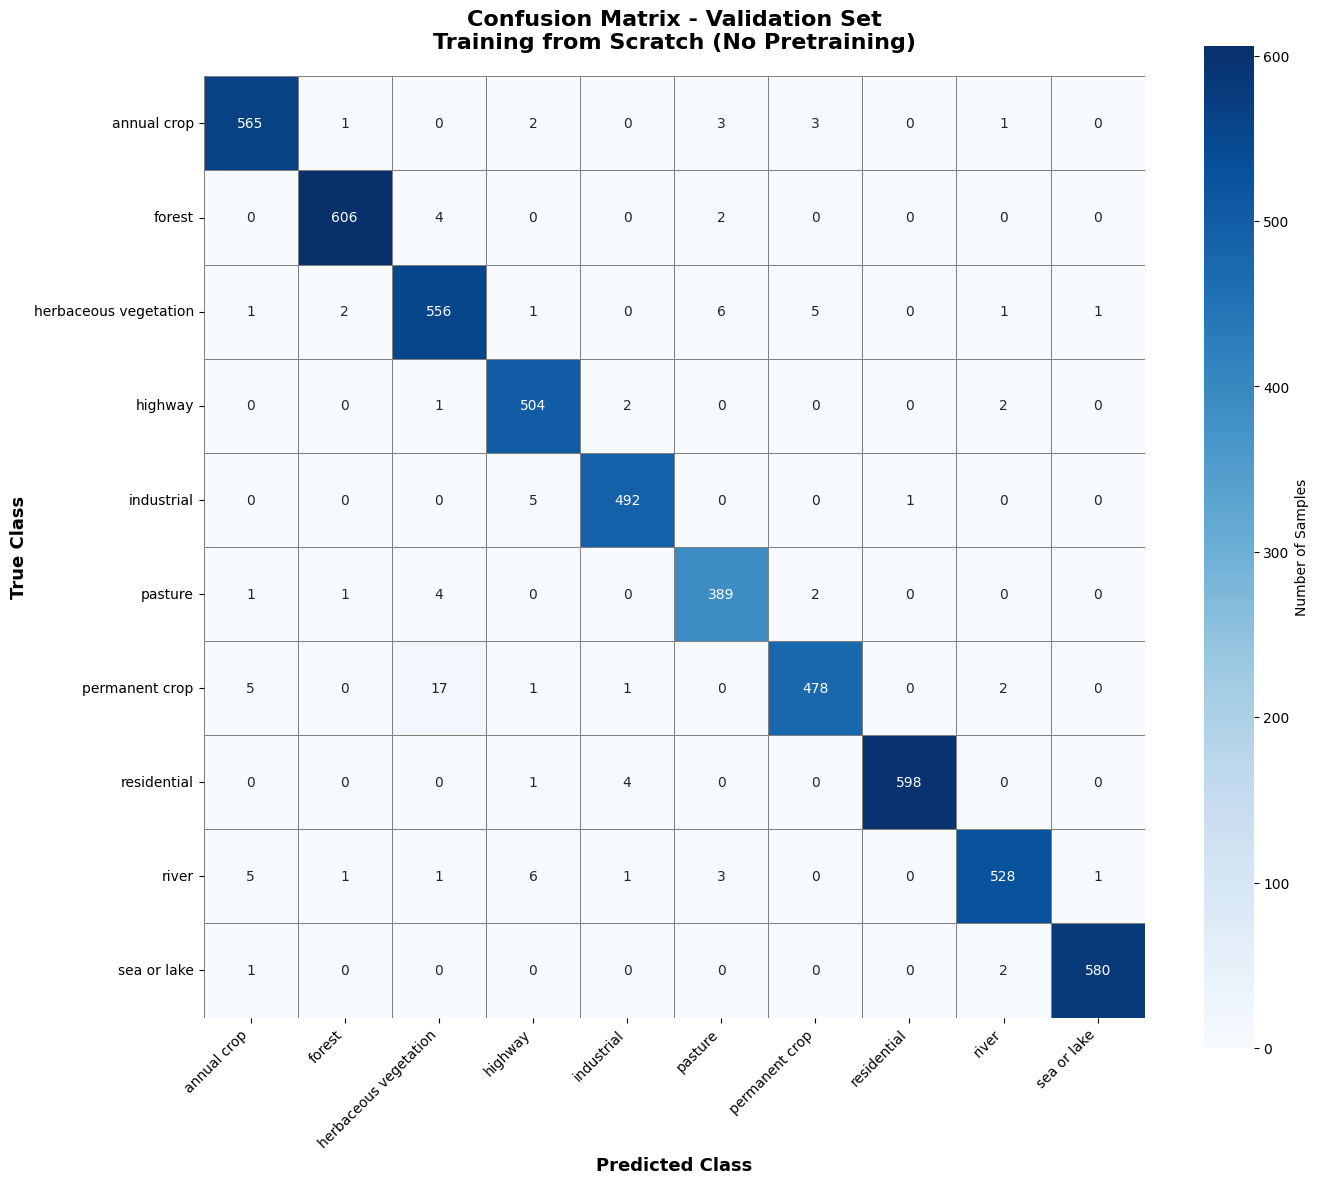


CLASSIFICATION REPORT
                       precision    recall  f1-score   support

          annual crop     0.9775    0.9826    0.9801       575
               forest     0.9918    0.9902    0.9910       612
herbaceous vegetation     0.9537    0.9703    0.9619       573
              highway     0.9692    0.9902    0.9796       509
           industrial     0.9840    0.9880    0.9860       498
              pasture     0.9653    0.9798    0.9725       397
       permanent crop     0.9795    0.9484    0.9637       504
          residential     0.9983    0.9917    0.9950       603
                river     0.9851    0.9670    0.9760       546
          sea or lake     0.9966    0.9949    0.9957       583

             accuracy                         0.9807      5400
            macro avg     0.9801    0.9803    0.9801      5400
         weighted avg     0.9809    0.9807    0.9807      5400


PER-CLASS ACCURACY
annual crop         :  98.26% ( 565/ 575)
forest              :  99.02% 

In [20]:
# Generate confusion matrix on validation set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

print("="*80)
print("📊 GENERATING CONFUSION MATRIX")
print("="*80)

# Set model to evaluation mode
supervised_model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

print("\nEvaluating on validation set...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Processing"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = supervised_model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100

# Plot confusion matrix
plt.figure(figsize=(14, 12))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ID_CLASS_NAMES, 
            yticklabels=ID_CLASS_NAMES,
            cbar_kws={'label': 'Number of Samples'},
            square=True,
            linewidths=0.5,
            linecolor='gray')

plt.title('Confusion Matrix - Validation Set\nTraining from Scratch (No Pretraining)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_labels, all_preds, 
                          target_names=ID_CLASS_NAMES, 
                          digits=4))

# Print per-class accuracy
print("\n" + "="*80)
print("PER-CLASS ACCURACY")
print("="*80)
for i, class_name in enumerate(ID_CLASS_NAMES):
    print(f"{class_name:20s}: {per_class_acc[i]:6.2f}% ({cm[i, i]:4d}/{cm[i].sum():4d})")

print("\n" + "="*80)
print(f"Overall Validation Accuracy: {(all_preds == all_labels).mean() * 100:.2f}%")
print("="*80)

## Confusion Matrix - Best Model (98.13% Validation Accuracy)

/tmp/ipykernel_31067/372215442.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_best = torch.load(best_model_path, map_location=device)


📊 LOADING BEST MODEL AND GENERATING CONFUSION MATRIX

✓ Loaded best model from: best_supervised_model_no_pretrain.pth
  Saved at epoch: 97
  Validation accuracy: 98.13%

Evaluating on validation set...


Processing: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]



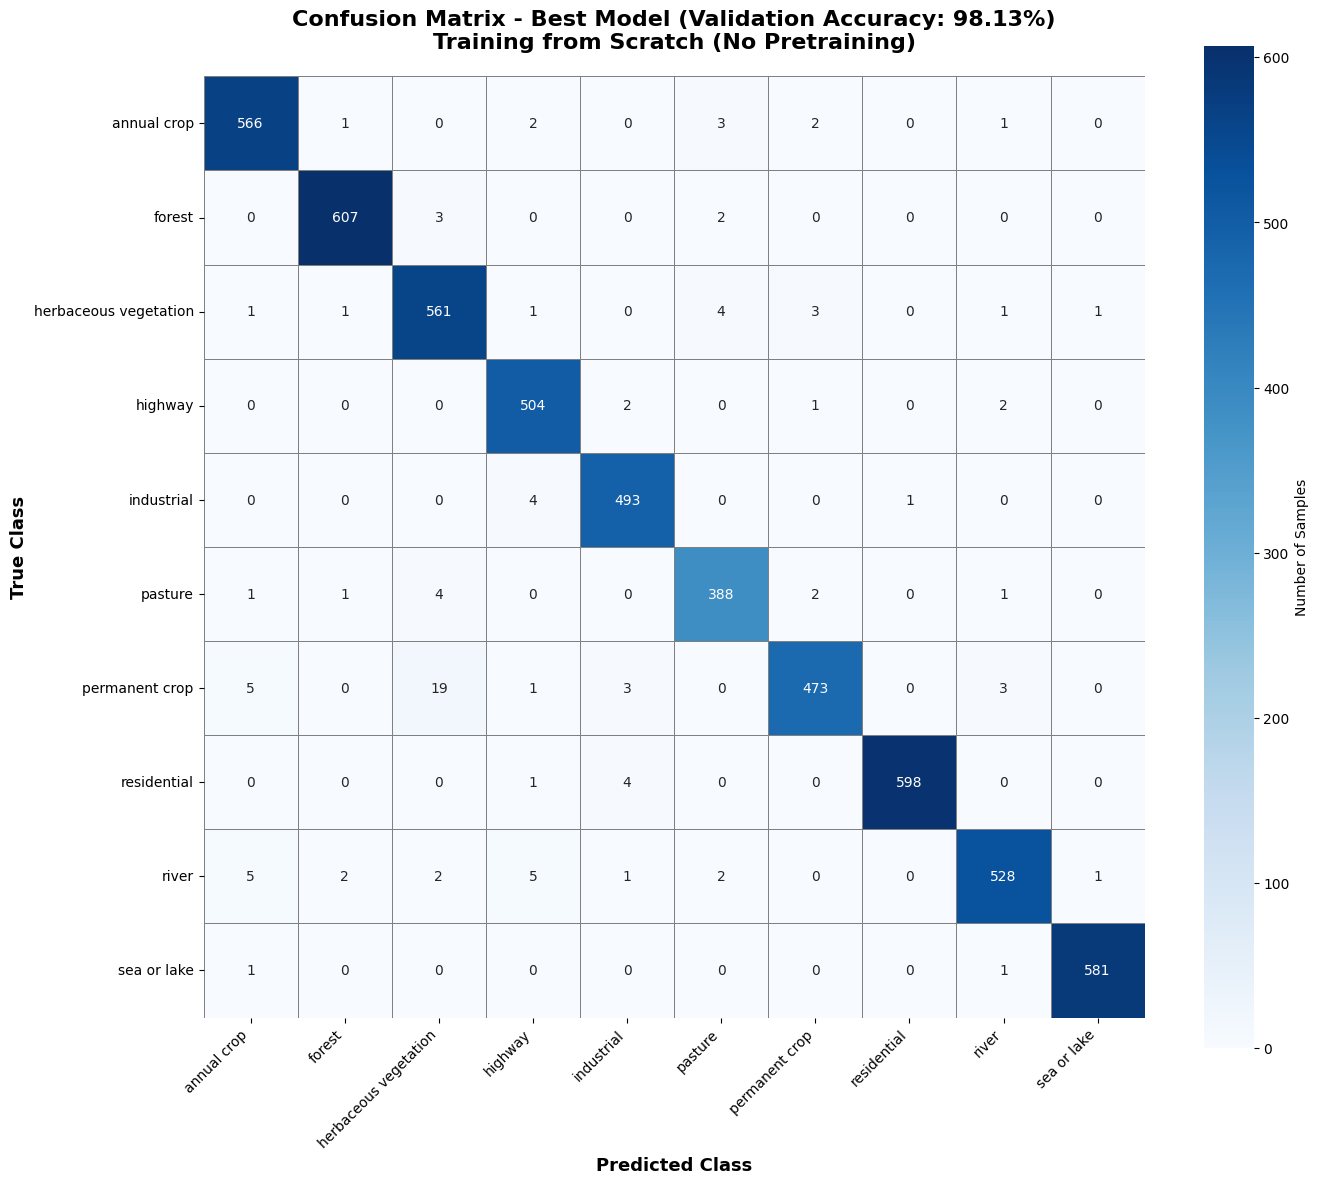


CLASSIFICATION REPORT - BEST MODEL
                       precision    recall  f1-score   support

          annual crop     0.9775    0.9843    0.9809       575
               forest     0.9918    0.9918    0.9918       612
herbaceous vegetation     0.9525    0.9791    0.9656       573
              highway     0.9730    0.9902    0.9815       509
           industrial     0.9801    0.9900    0.9850       498
              pasture     0.9724    0.9773    0.9749       397
       permanent crop     0.9834    0.9385    0.9604       504
          residential     0.9983    0.9917    0.9950       603
                river     0.9832    0.9670    0.9751       546
          sea or lake     0.9966    0.9966    0.9966       583

             accuracy                         0.9813      5400
            macro avg     0.9809    0.9807    0.9807      5400
         weighted avg     0.9814    0.9813    0.9813      5400


PER-CLASS ACCURACY - BEST MODEL
annual crop         :  98.43% ( 566/ 575)
fore

In [21]:
# Load the best model checkpoint and generate confusion matrix
print("="*80)
print("📊 LOADING BEST MODEL AND GENERATING CONFUSION MATRIX")
print("="*80)

# Load best model checkpoint
best_model_path = 'best_supervised_model_no_pretrain.pth'
checkpoint_best = torch.load(best_model_path, map_location=device)
supervised_model.load_state_dict(checkpoint_best['model_state_dict'])
supervised_model.eval()

print(f"\n✓ Loaded best model from: {best_model_path}")
print(f"  Saved at epoch: {checkpoint_best['epoch']}")
print(f"  Validation accuracy: {checkpoint_best['val_acc']:.2f}%")

# Collect predictions and true labels
all_preds_best = []
all_labels_best = []

print("\nEvaluating on validation set...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Processing"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = supervised_model(images)
        _, predicted = outputs.max(1)
        
        all_preds_best.extend(predicted.cpu().numpy())
        all_labels_best.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds_best = np.array(all_preds_best)
all_labels_best = np.array(all_labels_best)

# Generate confusion matrix
cm_best = confusion_matrix(all_labels_best, all_preds_best)

# Calculate per-class accuracy
per_class_acc_best = cm_best.diagonal() / cm_best.sum(axis=1) * 100

# Plot confusion matrix
plt.figure(figsize=(14, 12))

# Create heatmap
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ID_CLASS_NAMES, 
            yticklabels=ID_CLASS_NAMES,
            cbar_kws={'label': 'Number of Samples'},
            square=True,
            linewidths=0.5,
            linecolor='gray')

plt.title(f'Confusion Matrix - Best Model (Validation Accuracy: {checkpoint_best["val_acc"]:.2f}%)\nTraining from Scratch (No Pretraining)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT - BEST MODEL")
print("="*80)
print(classification_report(all_labels_best, all_preds_best, 
                          target_names=ID_CLASS_NAMES, 
                          digits=4))

# Print per-class accuracy
print("\n" + "="*80)
print("PER-CLASS ACCURACY - BEST MODEL")
print("="*80)
for i, class_name in enumerate(ID_CLASS_NAMES):
    print(f"{class_name:20s}: {per_class_acc_best[i]:6.2f}% ({cm_best[i, i]:4d}/{cm_best[i].sum():4d})")

overall_acc = (all_preds_best == all_labels_best).mean() * 100
print("\n" + "="*80)
print(f"Overall Validation Accuracy: {overall_acc:.2f}%")
print("="*80)

# Calculate misclassification analysis
print("\n" + "="*80)
print("MOST COMMON MISCLASSIFICATIONS")
print("="*80)
misclass_pairs = []
for i in range(len(ID_CLASS_NAMES)):
    for j in range(len(ID_CLASS_NAMES)):
        if i != j and cm_best[i, j] > 0:
            misclass_pairs.append((ID_CLASS_NAMES[i], ID_CLASS_NAMES[j], cm_best[i, j]))

# Sort by count
misclass_pairs.sort(key=lambda x: x[2], reverse=True)

# Print top 10 misclassifications
for i, (true_class, pred_class, count) in enumerate(misclass_pairs[:10], 1):
    print(f"{i:2d}. {true_class:20s} → {pred_class:20s}: {count:3d} samples")

In [22]:
# Save the final fine-tuned supervised model
import os

from datetime import datetime

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save path with timestamp
# PRETRAINED_MODEL_PATH = f'models/best_contrastive_model_50Ep_{timestamp}.pth'

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save paths with best accuracy and progressive unfreezing indicator
FINETUNED_MODEL_PATH = f'models/best_supervised_model_progressive_unfr_acc{best_val_acc:.2f}_{timestamp}.pth'
FINAL_MODEL_PATH = f'models/final_supervised_model_progressive_unfr_acc{val_accs[-1]:.2f}_{timestamp}.pth'

# The best model was already saved during training
# Let's also save the final model state for comparison
torch.save({
    'epoch': NUM_EPOCHS - 1,
    'model_state_dict': supervised_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_accs[-1],
    'train_acc': train_accs[-1],
    'best_val_acc': best_val_acc,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'training_method': 'progressive_unfreezing',
}, FINAL_MODEL_PATH)

print("="*80)
print("✅ FINE-TUNED MODEL SAVED SUCCESSFULLY (Progressive Unfreezing)")
print("="*80)
print(f"\n📁 Model Checkpoints:")
print(f"  Best Model: {FINETUNED_MODEL_PATH}")
print(f"  └─ Validation Accuracy: {best_val_acc:.2f}%")
print(f"  └─ Saved during training at best epoch")
print(f"  └─ Training Method: Progressive Unfreezing")
print(f"\n  Final Model: {FINAL_MODEL_PATH}")
print(f"  └─ Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  └─ Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  └─ Saved after {NUM_EPOCHS} epochs")
print(f"  └─ Training Method: Progressive Unfreezing")

print(f"\n📊 Training Summary:")
print(f"  Total Epochs: {NUM_EPOCHS}")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
print(f"  Final Val Accuracy: {val_accs[-1]:.2f}%")
print(f"  Improvement from Start: {(val_accs[-1] - val_accs[0]):.2f}%")

print(f"\n💡 Usage:")
print(f"  # Load best model for inference/OOD detection:")
print(f"  checkpoint = torch.load('{FINETUNED_MODEL_PATH}')")
print(f"  model.load_state_dict(checkpoint['model_state_dict'])")

print("="*80)

✅ FINE-TUNED MODEL SAVED SUCCESSFULLY (Progressive Unfreezing)

📁 Model Checkpoints:
  Best Model: models/best_supervised_model_progressive_unfr_acc98.13_20251130_140958.pth
  └─ Validation Accuracy: 98.13%
  └─ Saved during training at best epoch
  └─ Training Method: Progressive Unfreezing

  Final Model: models/final_supervised_model_progressive_unfr_acc98.07_20251130_140958.pth
  └─ Final Training Accuracy: 97.62%
  └─ Final Validation Accuracy: 98.07%
  └─ Saved after 200 epochs
  └─ Training Method: Progressive Unfreezing

📊 Training Summary:
  Total Epochs: 200
  Best Val Accuracy: 98.13%
  Final Val Accuracy: 98.07%
  Improvement from Start: 67.50%

💡 Usage:
  # Load best model for inference/OOD detection:
  checkpoint = torch.load('models/best_supervised_model_progressive_unfr_acc98.13_20251130_140958.pth')
  model.load_state_dict(checkpoint['model_state_dict'])


## 4. Comparison: With vs Without Contrastive Pretraining

To demonstrate the benefit of contrastive pretraining, we can train a baseline model from scratch (without pretraining) and compare performance.

In [23]:
# Summary comparison
print("="*80)
print("TRAINING SUMMARY: CONTRASTIVE PRETRAINING VS BASELINE")
print("="*80)

print("\n📊 Model Architecture:")
print(f"  Encoder: {encoder_params:,} parameters")
print(f"  Classifier: {classifier_params:,} parameters")
print(f"  Total: {total_params:,} parameters")



print("\n🎯 Stage 2 - Supervised Fine-tuning:")
print(f"  Method: Cross-entropy with pretrained encoder")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  ID Classes: {NUM_CLASSES}")
print(f"  Training samples: {len(train_indices)}")
print(f"  Validation samples: {len(val_indices)}")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")

print("\n🌡️ Progressive Unfreezing Schedule:")
print("  Phase 1 (Epochs 0-50):    Classifier only (encoder frozen)")
print("  Phase 2 (Epochs 51-100):  + Conv3 (top layer)")
print("  Phase 3 (Epochs 101-150): + Conv2 (middle layer)")
print("  Phase 4 (Epochs 151-200): + Conv1 (all layers, full fine-tuning)")

print("\n💡 Key Benefits of Contrastive Pretraining:")
print("  ✓ Better feature representations (learned from unlabeled data)")
print("  ✓ Improved generalization (reduces overfitting)")
print("  ✓ Better uncertainty estimates (more calibrated predictions)")
print("  ✓ Enhanced OOD detection (clearer ID/OOD separation)")

print("\n" + "="*80)

# Note: For a full comparison, you would train a baseline model without
# contrastive pretraining and compare the results. This is left as an
# exercise for ablation studies.

TRAINING SUMMARY: CONTRASTIVE PRETRAINING VS BASELINE

📊 Model Architecture:
  Encoder: 1,147,200 parameters
  Classifier: 265,482 parameters
  Total: 1,412,682 parameters

🎯 Stage 2 - Supervised Fine-tuning:
  Method: Cross-entropy with pretrained encoder
  Epochs: 200
  ID Classes: 10
  Training samples: 21600
  Validation samples: 5400
  Best validation accuracy: 98.13%

🌡️ Progressive Unfreezing Schedule:
  Phase 1 (Epochs 0-50):    Classifier only (encoder frozen)
  Phase 2 (Epochs 51-100):  + Conv3 (top layer)
  Phase 3 (Epochs 101-150): + Conv2 (middle layer)
  Phase 4 (Epochs 151-200): + Conv1 (all layers, full fine-tuning)

💡 Key Benefits of Contrastive Pretraining:
  ✓ Better feature representations (learned from unlabeled data)
  ✓ Improved generalization (reduces overfitting)
  ✓ Better uncertainty estimates (more calibrated predictions)
  ✓ Enhanced OOD detection (clearer ID/OOD separation)



## 5. Monte Carlo Dropout for Uncertainty Estimation

Now we use the trained model with MC Dropout to estimate uncertainty and detect OOD samples.

In [24]:
# Load best supervised model for OOD evaluation
# Use the saved model path from training
checkpoint = torch.load(FINAL_MODEL_PATH, map_location=device)
supervised_model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best supervised model from epoch {checkpoint['epoch']+1}")
print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Assign to 'model' variable for compatibility with existing code
model = supervised_model

print("\n✓ Model ready for uncertainty estimation and OOD detection")

✓ Loaded best supervised model from epoch 200
  Validation accuracy: 98.07%

✓ Model ready for uncertainty estimation and OOD detection


/tmp/ipykernel_31067/1312248030.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(FINAL_MODEL_PATH, map_location=device)


In [25]:
# CELL 1: MC Dropout Function
# ----------------------------------------------------------------------------
def mc_dropout_predict(model, loader, T=50, device='cuda'):
    """
    Perform MC Dropout inference for uncertainty estimation.
    
    Args:
        model: Trained model with dropout layers
        loader: DataLoader
        T: Number of MC samples (forward passes with dropout)
        device: cuda or cpu
        
    Returns:
        all_probs: [N, T, C] - Probabilities for each sample, MC sample, and class
        all_labels: [N] - True labels
    """
    model.train()  # Enable dropout
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f'MC Dropout (T={T})'):
            images = images.to(device)
            batch_probs = []
            
            # Run T forward passes with dropout enabled
            for _ in range(T):
                logits = model(images)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs.cpu())
            
            # Stack: [T, B, C] -> [B, T, C]
            batch_probs = torch.stack(batch_probs, dim=1)
            all_probs.append(batch_probs)
            all_labels.append(labels)
    
    all_probs = torch.cat(all_probs, dim=0)  # [N, T, C]
    all_labels = torch.cat(all_labels, dim=0)  # [N]
    
    return all_probs, all_labels

print("✓ MC Dropout prediction function defined")
print(f"  Will use {MC_SAMPLES} forward passes for uncertainty estimation")


✓ MC Dropout prediction function defined
  Will use 50 forward passes for uncertainty estimation


In [26]:

# CELL 2: Run MC Dropout on ID and OOD Data
# ----------------------------------------------------------------------------
# Get MC Dropout predictions for ID (validation) data
print("="*80)
print("RUNNING MC DROPOUT ON IN-DISTRIBUTION (VALIDATION) DATA")
print("="*80)
id_probs, id_labels_list = mc_dropout_predict(model, val_loader, T=MC_SAMPLES, device=device)

# Get MC Dropout predictions for OOD data
print("\n" + "="*80)
print("RUNNING MC DROPOUT ON OUT-OF-DISTRIBUTION DATA")
print("="*80)
ood_probs, ood_labels_list = mc_dropout_predict(model, ood_loader, T=MC_SAMPLES, device=device)

print(f"\n✓ MC Dropout predictions complete")
print(f"  ID samples: {len(id_probs)}")
print(f"  OOD samples: {len(ood_probs)}")
print(f"  MC samples per image: {MC_SAMPLES}")

RUNNING MC DROPOUT ON IN-DISTRIBUTION (VALIDATION) DATA


MC Dropout (T=50): 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]



RUNNING MC DROPOUT ON OUT-OF-DISTRIBUTION DATA


MC Dropout (T=50): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


✓ MC Dropout predictions complete
  ID samples: 5400
  OOD samples: 500
  MC samples per image: 50


In [27]:
# CELL 3: Compute Uncertainty Scores
# ----------------------------------------------------------------------------
def compute_uncertainty_scores(probs):
    """
    Compute multiple uncertainty scores from MC Dropout predictions.
    
    Args:
        probs: [N, T, C] - Probabilities from MC Dropout
        
    Returns:
        Dictionary with various uncertainty scores
    """
    # Mean prediction across MC samples
    mean_probs = probs.mean(dim=1)  # [N, C]
    
    # 1. Maximum Softmax Probability (MSP) - Higher = more confident = likely ID
    msp = mean_probs.max(dim=1)[0]  # [N]
    
    # 2. Predictive Entropy - Higher = more uncertain = likely OOD
    entropy = -(mean_probs * torch.log(mean_probs + 1e-10)).sum(dim=1)  # [N]
    
    # 3. Mutual Information (Epistemic Uncertainty) - Higher = more uncertain = likely OOD
    # MI = H(y|x) - E[H(y|x,θ)]
    expected_entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=2).mean(dim=1)  # [N]
    mutual_info = entropy - expected_entropy  # [N]
    
    # 4. Variance of predictions - Higher = more uncertain = likely OOD
    variance = probs.var(dim=1).mean(dim=1)  # [N]
    
    return {
        'msp': msp.numpy(),
        'entropy': entropy.numpy(),
        'mutual_info': mutual_info.numpy(),
        'variance': variance.numpy(),
        'mean_probs': mean_probs.numpy()
    }

# Compute scores for ID and OOD
print("Computing uncertainty scores...")
id_scores = compute_uncertainty_scores(id_probs)
ood_scores = compute_uncertainty_scores(ood_probs)

print(f"\n✓ Uncertainty scores computed")
print(f"\nAverage scores for ID data:")
print(f"  MSP (confidence): {id_scores['msp'].mean():.4f}")
print(f"  Entropy: {id_scores['entropy'].mean():.4f}")
print(f"  Mutual Info: {id_scores['mutual_info'].mean():.4f}")
print(f"  Variance: {id_scores['variance'].mean():.4f}")

print(f"\nAverage scores for OOD data:")
print(f"  MSP (confidence): {ood_scores['msp'].mean():.4f}")
print(f"  Entropy: {ood_scores['entropy'].mean():.4f}")
print(f"  Mutual Info: {ood_scores['mutual_info'].mean():.4f}")
print(f"  Variance: {ood_scores['variance'].mean():.4f}")


Computing uncertainty scores...

✓ Uncertainty scores computed

Average scores for ID data:
  MSP (confidence): 0.9641
  Entropy: 0.1095
  Mutual Info: 0.0265
  Variance: 0.0012

Average scores for OOD data:
  MSP (confidence): 0.7036
  Entropy: 0.7848
  Mutual Info: 0.2853
  Variance: 0.0144


In [28]:
# CELL 4: Evaluate OOD Detection Performance
# ----------------------------------------------------------------------------
def evaluate_ood_detection(id_scores, ood_scores, score_name='MSP'):
    """
    Evaluate OOD detection performance.
    
    For MSP: ID should have higher scores (more confident)
    For Entropy/MI/Variance: OOD should have higher scores (more uncertain)
    """
    # Combine scores
    all_scores = np.concatenate([id_scores, ood_scores])
    
    # Labels: 0 = ID, 1 = OOD
    labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
    
    # For MSP, we want high scores for ID, so we flip the scores for metrics
    if score_name == 'MSP':
        scores_for_roc = -all_scores  # Flip so OOD has higher values
    else:
        scores_for_roc = all_scores  # Already in right direction
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores_for_roc)
    auroc = auc(fpr, tpr)
    
    # Compute AUPR
    precision, recall, _ = precision_recall_curve(labels, scores_for_roc)
    aupr = auc(recall, precision)
    
    # FPR at 95% TPR
    idx_95 = np.argmax(tpr >= 0.95)
    fpr_at_95 = fpr[idx_95]
    
    return {
        'auroc': auroc,
        'aupr': aupr,
        'fpr95': fpr_at_95,
        'fpr': fpr,
        'tpr': tpr
    }

# Evaluate all methods
print("="*80)
print("OOD DETECTION PERFORMANCE")
print("="*80)

methods = {
    'MSP (Max Softmax Probability)': ('msp', id_scores['msp'], ood_scores['msp']),
    'Entropy': ('entropy', id_scores['entropy'], ood_scores['entropy']),
    'Mutual Information': ('mutual_info', id_scores['mutual_info'], ood_scores['mutual_info']),
    'Variance': ('variance', id_scores['variance'], ood_scores['variance'])
}

results = {}
for name, (score_name, id_s, ood_s) in methods.items():
    res = evaluate_ood_detection(id_s, ood_s, score_name)
    results[name] = res
    
    print(f"\n{name}:")
    print(f"  AUROC: {res['auroc']:.4f}")
    print(f"  AUPR: {res['aupr']:.4f}")
    print(f"  FPR@95TPR: {res['fpr95']:.4f}")

# Find best method
best_method_name = max(results.items(), key=lambda x: x[1]['auroc'])[0]
print(f"\n{'='*80}")
print(f"🏆 BEST METHOD: {best_method_name}")
print(f"  AUROC: {results[best_method_name]['auroc']:.4f}")
print(f"{'='*80}")


OOD DETECTION PERFORMANCE

MSP (Max Softmax Probability):
  AUROC: 0.0994
  AUPR: 0.0453
  FPR@95TPR: 0.9996

Entropy:
  AUROC: 0.9084
  AUPR: 0.6294
  FPR@95TPR: 0.4639

Mutual Information:
  AUROC: 0.9255
  AUPR: 0.7247
  FPR@95TPR: 0.4048

Variance:
  AUROC: 0.9165
  AUPR: 0.6625
  FPR@95TPR: 0.4304

🏆 BEST METHOD: Mutual Information
  AUROC: 0.9255


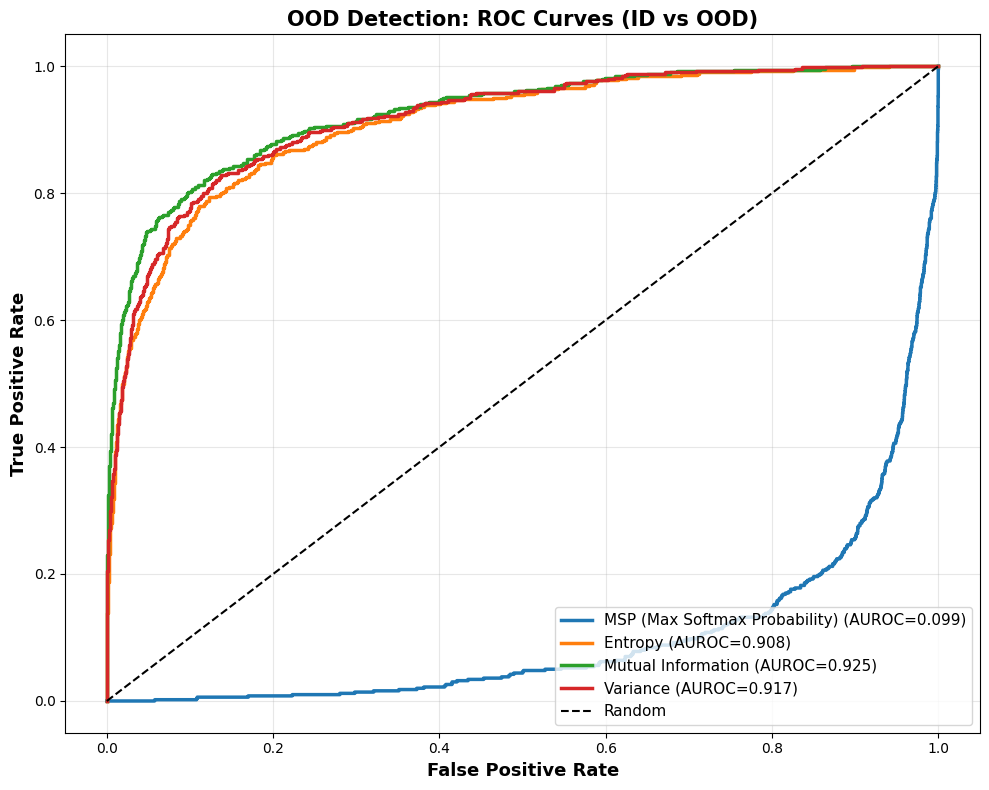

📊 ROC CURVES PLOTTED
Higher AUROC = Better OOD detection performance
Perfect detection: AUROC = 1.0
Random guessing: AUROC = 0.5


In [29]:
# CELL 5: Plot ROC Curves
# ----------------------------------------------------------------------------
# Plot ROC curves for all methods
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for (name, res), color in zip(results.items(), colors):
    ax.plot(res['fpr'], res['tpr'], label=f"{name} (AUROC={res['auroc']:.3f})", 
            linewidth=2.5, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('OOD Detection: ROC Curves (ID vs OOD)', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("="*80)
print("📊 ROC CURVES PLOTTED")
print("="*80)
print("Higher AUROC = Better OOD detection performance")
print("Perfect detection: AUROC = 1.0")
print("Random guessing: AUROC = 0.5")
print("="*80)


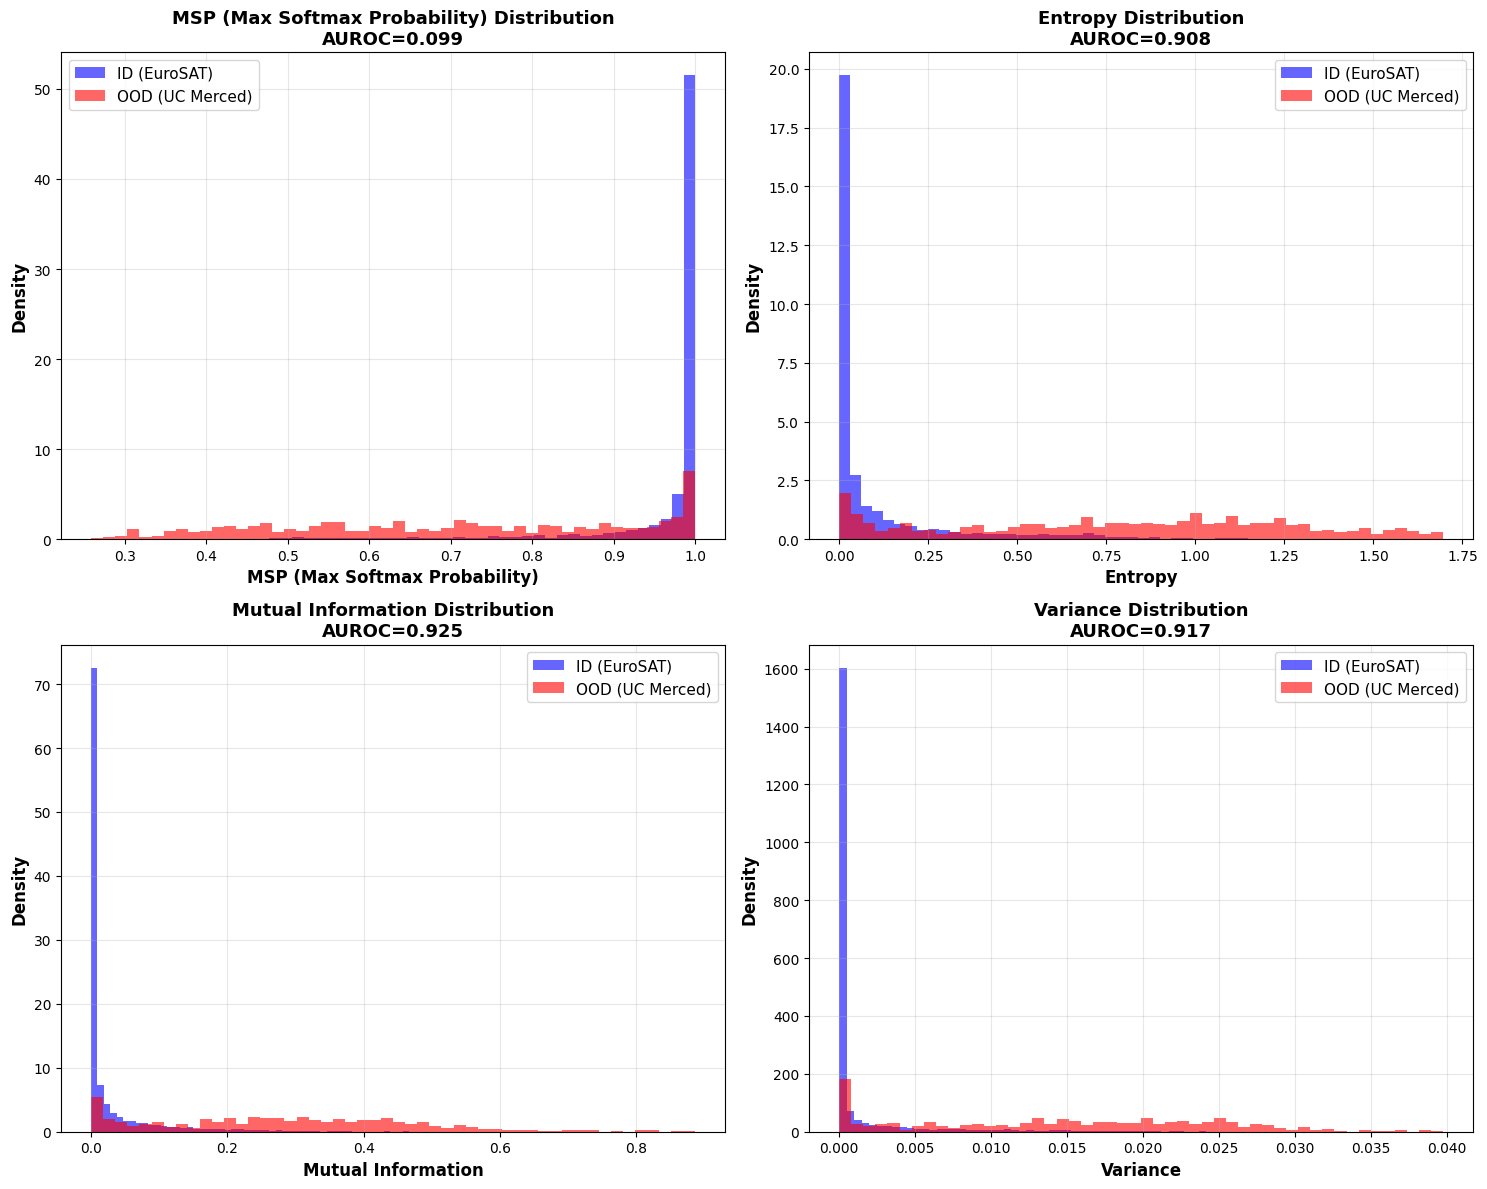

📊 UNCERTAINTY SCORE DISTRIBUTIONS
✓ MSP: ID samples should have HIGHER values (more confident)
✓ Entropy/MI/Variance: OOD samples should have HIGHER values (more uncertain)
✓ Good separation = Good OOD detection


In [30]:

# CELL 6: Plot Uncertainty Score Distributions
# ----------------------------------------------------------------------------
# Plot uncertainty score distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (name, (score_name, id_s, ood_s)) in enumerate(methods.items()):
    ax = axes[idx]
    
    # Plot histograms
    ax.hist(id_s, bins=50, alpha=0.6, label='ID (EuroSAT)', color='blue', density=True)
    ax.hist(ood_s, bins=50, alpha=0.6, label='OOD (UC Merced)', color='red', density=True)
    
    ax.set_xlabel(name, fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'{name} Distribution\nAUROC={results[name]["auroc"]:.3f}', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*80)
print("📊 UNCERTAINTY SCORE DISTRIBUTIONS")
print("="*80)
print("✓ MSP: ID samples should have HIGHER values (more confident)")
print("✓ Entropy/MI/Variance: OOD samples should have HIGHER values (more uncertain)")
print("✓ Good separation = Good OOD detection")
print("="*80)

🎨 VISUALIZING OOD DETECTION SAMPLES


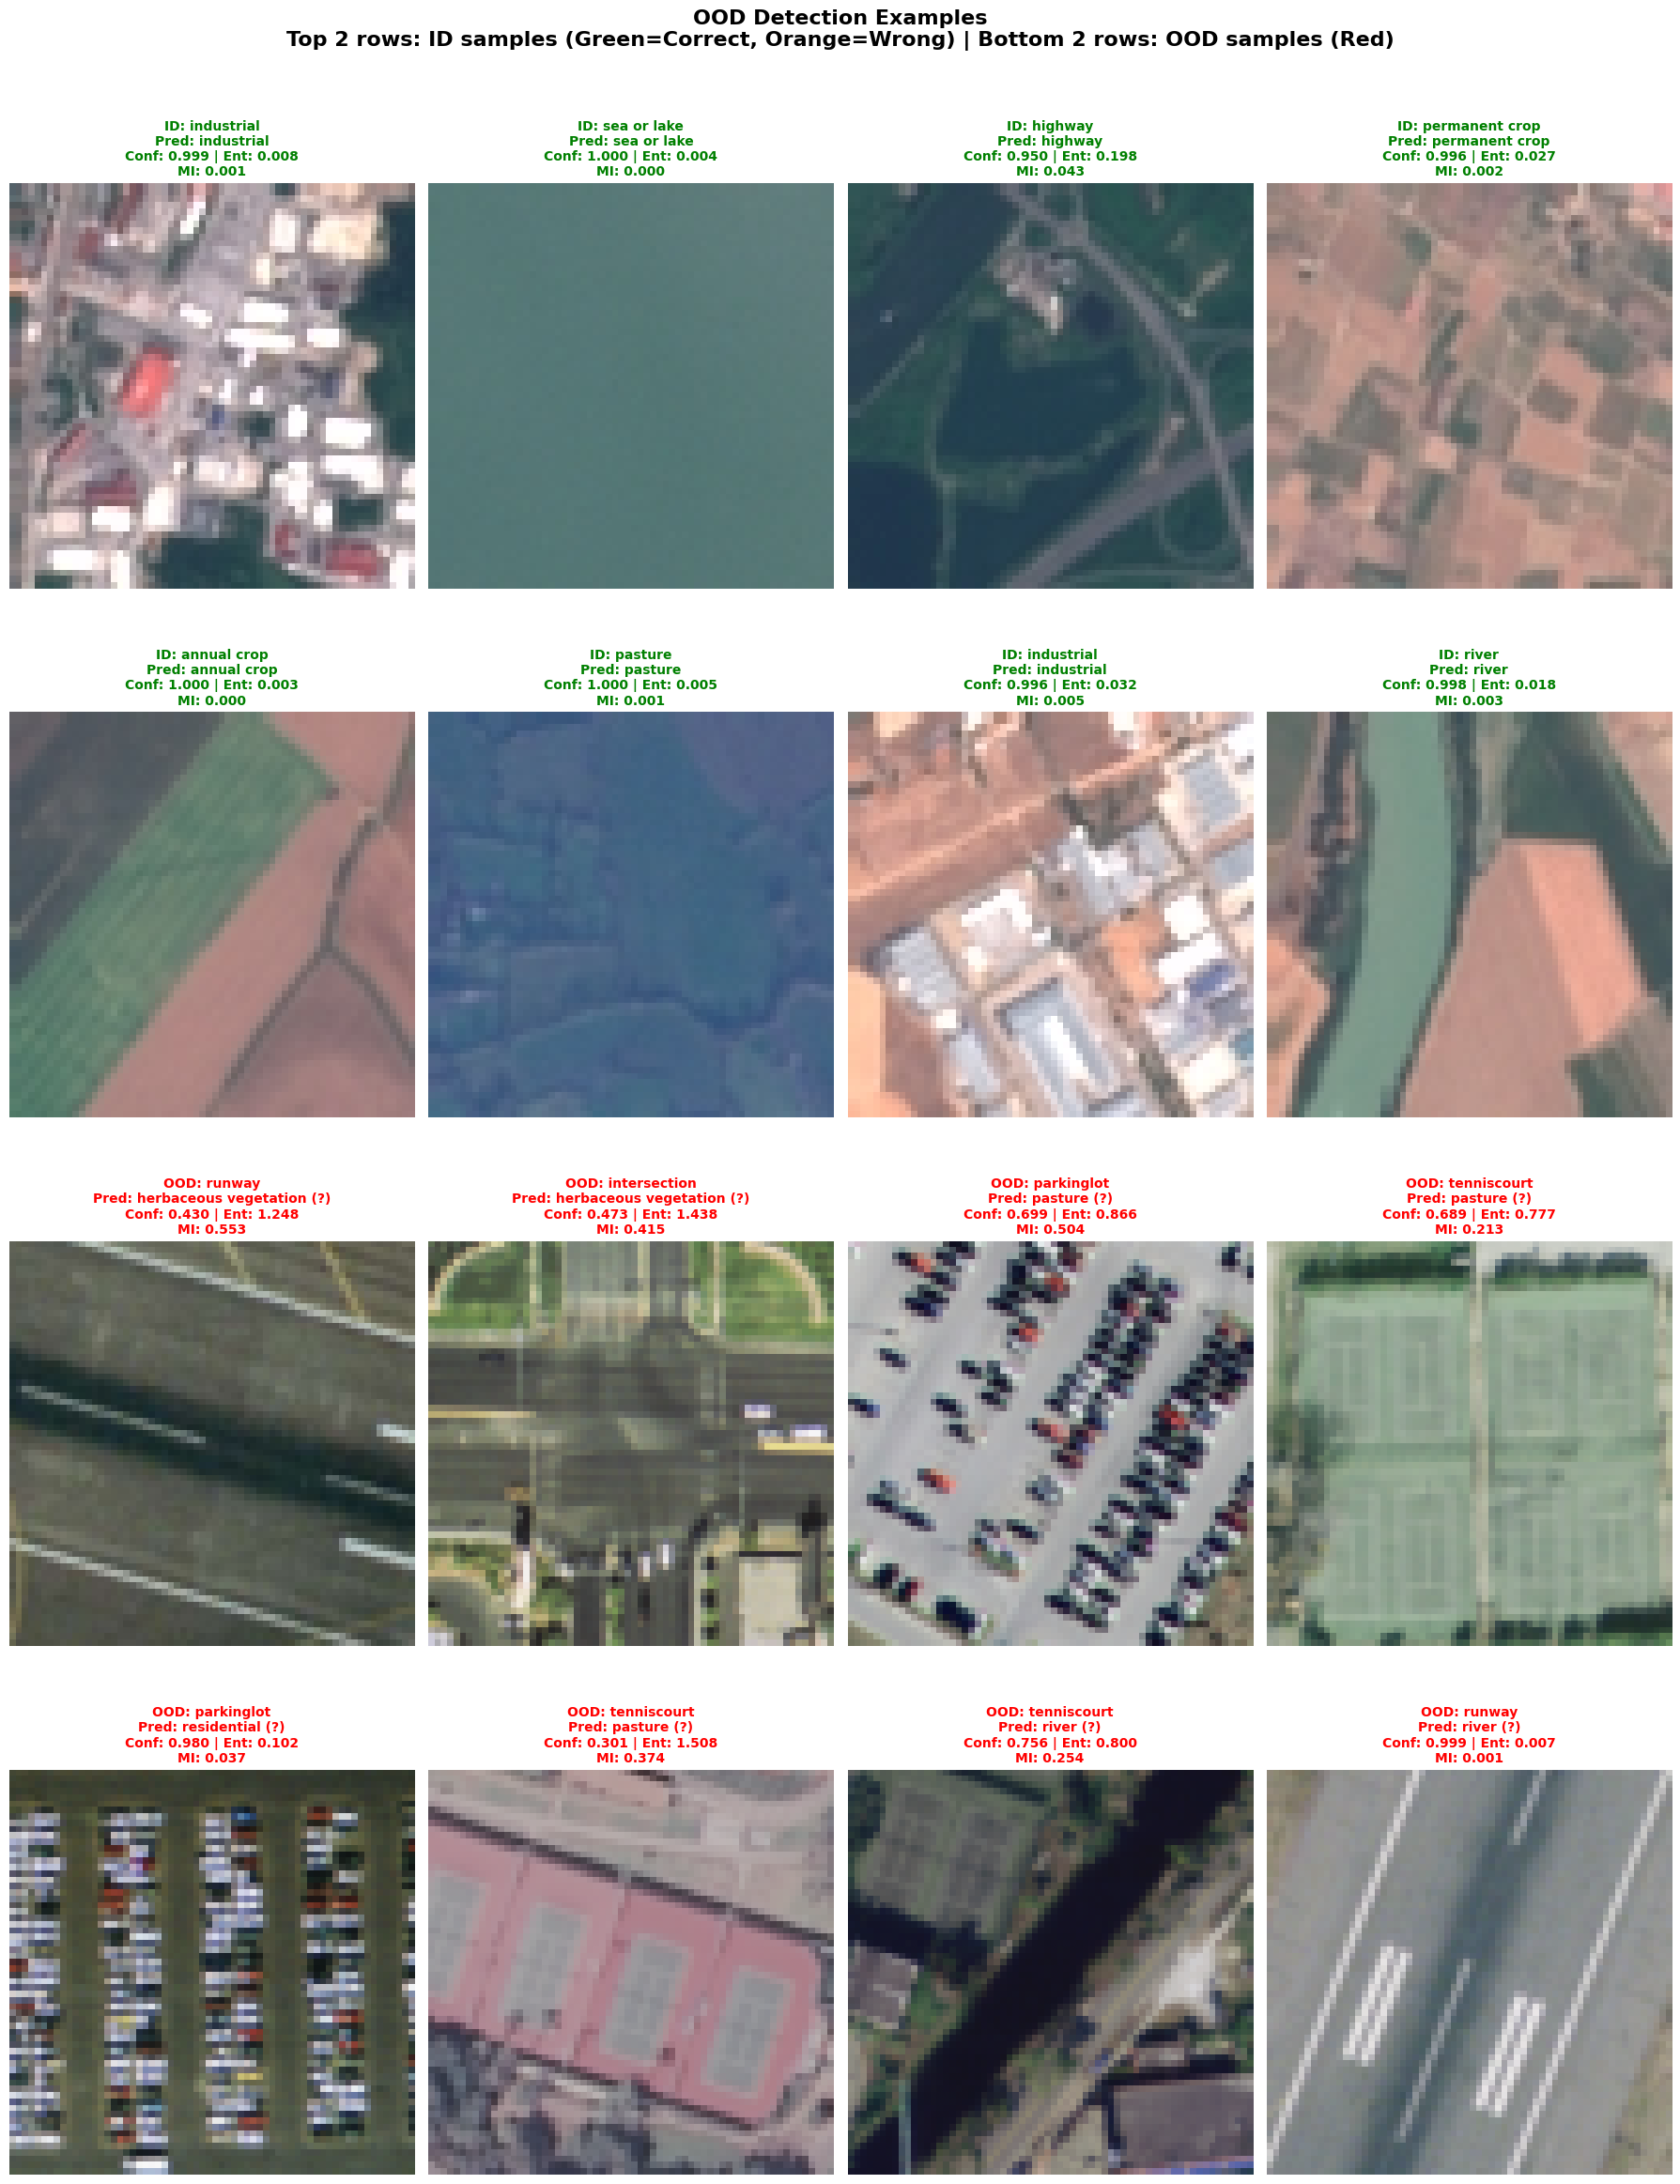


📊 INTERPRETATION
✓ ID samples (top): Should have HIGH confidence, LOW entropy/MI
✓ OOD samples (bottom): Should have LOW confidence, HIGH entropy/MI
✓ The model predicts an ID class for OOD samples (with ?) - this is expected!
✓ High uncertainty scores help us detect that OOD predictions are unreliable


In [31]:
# CELL 7: Visualize Sample OOD Detections
# ----------------------------------------------------------------------------
def visualize_ood_detection_samples(val_dataset, ood_dataset, id_scores, ood_scores, 
                                    id_probs, ood_probs, num_samples=8):
    """
    Visualize sample images with their OOD detection scores.
    """
    fig, axes = plt.subplots(4, 4, figsize=(18, 24))
    
    # Select random ID samples (top 2 rows)
    id_indices = np.random.choice(len(val_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(id_indices):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        img, label = val_dataset[idx]
        img_display = denormalize(img).numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)
        
        # Get prediction
        pred_probs = id_scores['mean_probs'][idx]
        pred_class = pred_probs.argmax()
        confidence = id_scores['msp'][idx]
        entropy = id_scores['entropy'][idx]
        mi = id_scores['mutual_info'][idx]
        
        ax.imshow(img_display)
        title = f"ID: {ID_CLASS_NAMES[label]}\n"
        title += f"Pred: {ID_CLASS_NAMES[pred_class]}\n"
        title += f"Conf: {confidence:.3f} | Ent: {entropy:.3f}\n"
        title += f"MI: {mi:.3f}"
        
        # Color based on correctness
        color = 'green' if pred_class == label else 'orange'
        ax.set_title(title, fontsize=10, fontweight='bold', color=color)
        ax.axis('off')
    
    # Select random OOD samples (bottom 2 rows)
    ood_indices = np.random.choice(len(ood_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(ood_indices):
        row = 2 + i // 4
        col = i % 4
        ax = axes[row, col]
        
        img, label = ood_dataset[idx]
        img_display = denormalize(img).numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)
        
        # Get prediction
        pred_probs = ood_scores['mean_probs'][idx]
        pred_class = pred_probs.argmax()
        confidence = ood_scores['msp'][idx]
        entropy = ood_scores['entropy'][idx]
        mi = ood_scores['mutual_info'][idx]
        
        # Get OOD class name - simplified
        ood_class_name = "OOD"
        for ood_name in OOD_CLASS_NAMES:
            if label == ood_label_map[ood_name]:
                ood_class_name = ood_name
                break
        
        ax.imshow(img_display)
        title = f"OOD: {ood_class_name}\n"
        title += f"Pred: {ID_CLASS_NAMES[pred_class]} (?)\n"
        title += f"Conf: {confidence:.3f} | Ent: {entropy:.3f}\n"
        title += f"MI: {mi:.3f}"
        
        # Red for OOD samples
        ax.set_title(title, fontsize=10, fontweight='bold', color='red')
        ax.axis('off')
    
    plt.suptitle('OOD Detection Examples\n' + 
                 'Top 2 rows: ID samples (Green=Correct, Orange=Wrong) | Bottom 2 rows: OOD samples (Red)',
                 fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# Visualize samples
print("="*80)
print("🎨 VISUALIZING OOD DETECTION SAMPLES")
print("="*80)
visualize_ood_detection_samples(val_dataset, ood_dataset_specific, id_scores, ood_scores,
                                id_probs, ood_probs, num_samples=8)

print("\n" + "="*80)
print("📊 INTERPRETATION")
print("="*80)
print("✓ ID samples (top): Should have HIGH confidence, LOW entropy/MI")
print("✓ OOD samples (bottom): Should have LOW confidence, HIGH entropy/MI")
print("✓ The model predicts an ID class for OOD samples (with ?) - this is expected!")
print("✓ High uncertainty scores help us detect that OOD predictions are unreliable")
print("="*80)

In [32]:
# CELL 8: Performance Summary Dashboard
# ----------------------------------------------------------------------------
# Create comprehensive performance dashboard
print("\n" + "="*100)
print(" " * 35 + "🎯 FINAL PERFORMANCE DASHBOARD")
print("="*100)

print("\n📊 SUPERVISED CLASSIFICATION PERFORMANCE (ID Data)")
print("-" * 100)
print(f"  Training Accuracy:      {train_accs[-1]:.2f}%")
print(f"  Validation Accuracy:    {val_accs[-1]:.2f}%")
print(f"  Best Val Accuracy:      {best_val_acc:.2f}%")
print(f"  ID Classes:             {NUM_CLASSES} classes from EuroSAT")
print(f"  Training Method:        From Scratch (No Pretraining)")

print("\n🔍 OOD DETECTION PERFORMANCE (ID vs OOD)")
print("-" * 100)
print(f"{'Method':<35} {'AUROC':<12} {'AUPR':<12} {'FPR@95TPR':<12}")
print("-" * 100)
for name, res in results.items():
    marker = "🏆 " if name == best_method_name else "   "
    print(f"{marker}{name:<33} {res['auroc']:.4f}       {res['aupr']:.4f}       {res['fpr95']:.4f}")

print("\n📈 UNCERTAINTY STATISTICS")
print("-" * 100)
print(f"{'Metric':<25} {'ID Mean':<15} {'OOD Mean':<15} {'Separation':<15}")
print("-" * 100)
print(f"{'MSP (Confidence)':<25} {id_scores['msp'].mean():.4f}          {ood_scores['msp'].mean():.4f}          {id_scores['msp'].mean() - ood_scores['msp'].mean():.4f}")
print(f"{'Entropy':<25} {id_scores['entropy'].mean():.4f}          {ood_scores['entropy'].mean():.4f}          {ood_scores['entropy'].mean() - id_scores['entropy'].mean():.4f}")
print(f"{'Mutual Information':<25} {id_scores['mutual_info'].mean():.4f}          {ood_scores['mutual_info'].mean():.4f}          {ood_scores['mutual_info'].mean() - id_scores['mutual_info'].mean():.4f}")
print(f"{'Variance':<25} {id_scores['variance'].mean():.4f}          {ood_scores['variance'].mean():.4f}          {ood_scores['variance'].mean() - id_scores['variance'].mean():.4f}")

print("\n🎯 KEY FINDINGS")
print("-" * 100)
print(f"  ✓ Best OOD Detection Method:  {best_method_name} (AUROC: {results[best_method_name]['auroc']:.4f})")
print(f"  ✓ ID Confidence (MSP):         {id_scores['msp'].mean():.4f} (higher is better)")
print(f"  ✓ OOD Confidence (MSP):        {ood_scores['msp'].mean():.4f} (lower indicates uncertainty)")
print(f"  ✓ OOD Entropy:                 {ood_scores['entropy'].mean():.4f} (higher indicates uncertainty)")
print(f"  ✓ MC Dropout Samples:          {MC_SAMPLES} forward passes")

print("\n💾 MODEL INFORMATION")
print("-" * 100)
print(f"  Best Model Path:        {FINETUNED_MODEL_PATH}")
print(f"  Final Model Path:       {FINAL_MODEL_PATH}")
print(f"  Training Epochs:        {NUM_EPOCHS}")
print(f"  Dropout Rate:           {DROPOUT_RATE}")
print(f"  Batch Size:             {BATCH_SIZE}")
print(f"  Pretraining:            None (trained from scratch)")

print("\n" + "="*100)
print(" " * 30 + "✅ OOD DETECTION EVALUATION COMPLETE!")
print("="*100)


                                   🎯 FINAL PERFORMANCE DASHBOARD

📊 SUPERVISED CLASSIFICATION PERFORMANCE (ID Data)
----------------------------------------------------------------------------------------------------
  Training Accuracy:      97.62%
  Validation Accuracy:    98.07%
  Best Val Accuracy:      98.13%
  ID Classes:             10 classes from EuroSAT
  Training Method:        From Scratch (No Pretraining)

🔍 OOD DETECTION PERFORMANCE (ID vs OOD)
----------------------------------------------------------------------------------------------------
Method                              AUROC        AUPR         FPR@95TPR   
----------------------------------------------------------------------------------------------------
   MSP (Max Softmax Probability)     0.0994       0.0453       0.9996
   Entropy                           0.9084       0.6294       0.4639
🏆 Mutual Information                0.9255       0.7247       0.4048
   Variance                          0.9165       

🎨 GENERATING UMAP VISUALIZATION OF FINE-TUNED ENCODER (STAGE II)
✅ UMAP already installed

📊 Extracting embeddings from fine-tuned encoder...
✅ UMAP already installed

📊 Extracting embeddings from fine-tuned encoder...


Extracting embeddings: 100%|██████████| 16/16 [00:00<00:00, 61.09it/s]
/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Extracted embeddings shape: (1000, 256)
✅ Labels shape: (1000,)
✅ Unique classes: 10

🔍 Performing UMAP dimensionality reduction...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sun Nov 30 14:10:19 2025 Construct fuzzy simplicial set
Sun Nov 30 14:10:19 2025 Finding Nearest Neighbors
Sun Nov 30 14:10:19 2025 Finding Nearest Neighbors
Sun Nov 30 14:10:21 2025 Finished Nearest Neighbor Search
Sun Nov 30 14:10:21 2025 Finished Nearest Neighbor Search
Sun Nov 30 14:10:22 2025 Construct embedding
Sun Nov 30 14:10:22 2025 Construct embedding


Epochs completed:  19%| █▉         96/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs


Epochs completed:  75%| ███████▌   375/500 [00:00]

	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:00]



	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Nov 30 14:10:23 2025 Finished embedding
✅ UMAP embedding shape: (1000, 2)

🎨 Creating UMAP visualization with class labels...

💾 Saved figure to: umap_visualizations/umap_class_boundaries_20251130_141023.png

💾 Saved figure to: umap_visualizations/umap_class_boundaries_20251130_141023.png


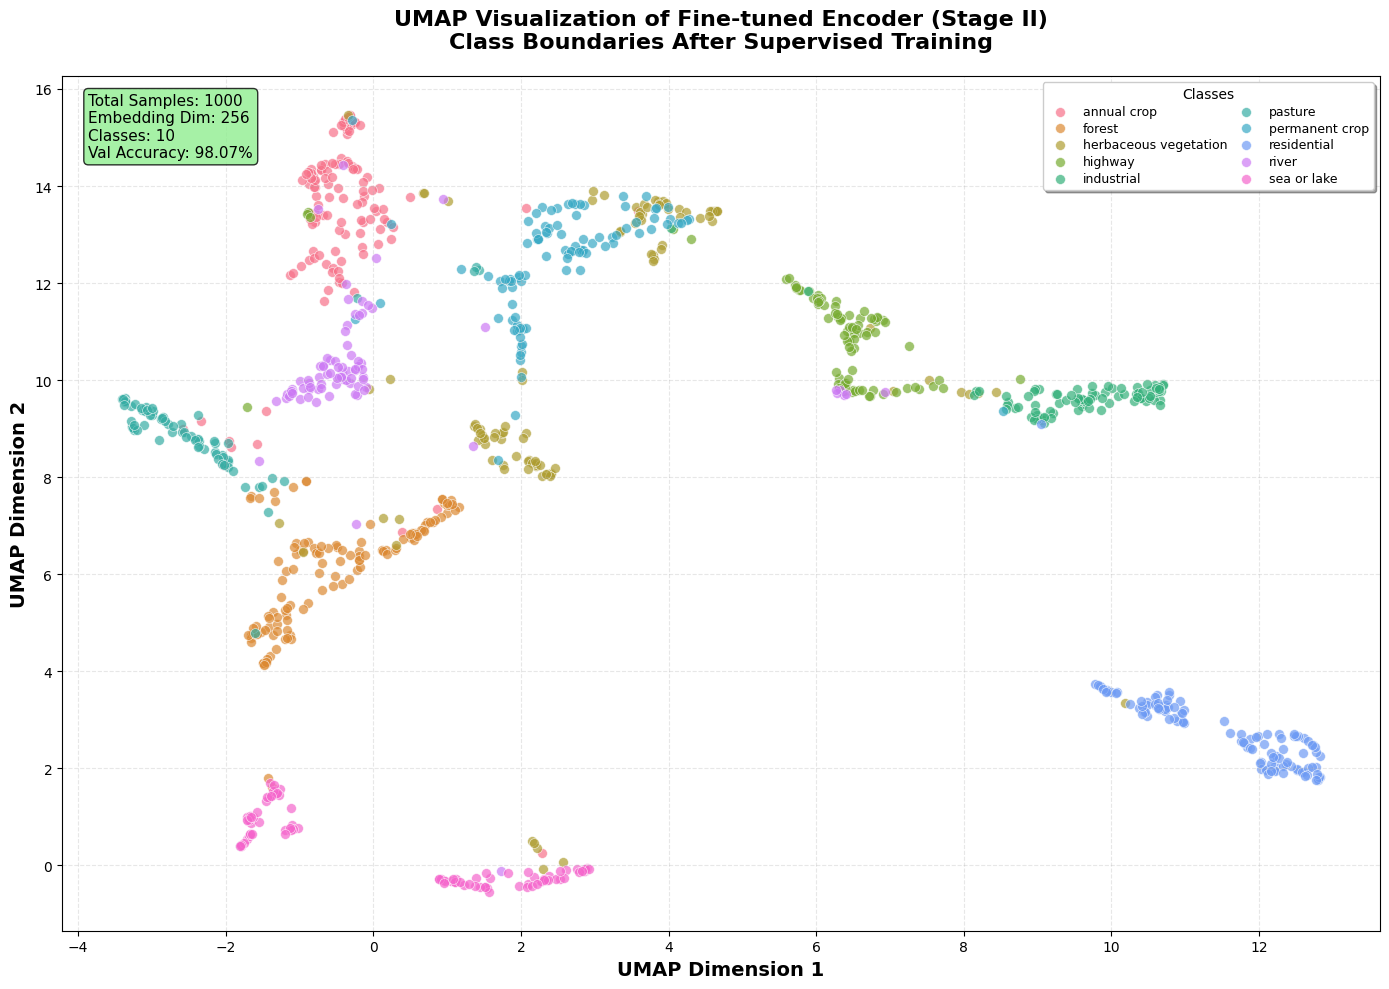


🎨 Creating visualization with class centroids...
💾 Saved figure to: umap_visualizations/umap_class_centroids_20251130_141023.png
💾 Saved figure to: umap_visualizations/umap_class_centroids_20251130_141023.png


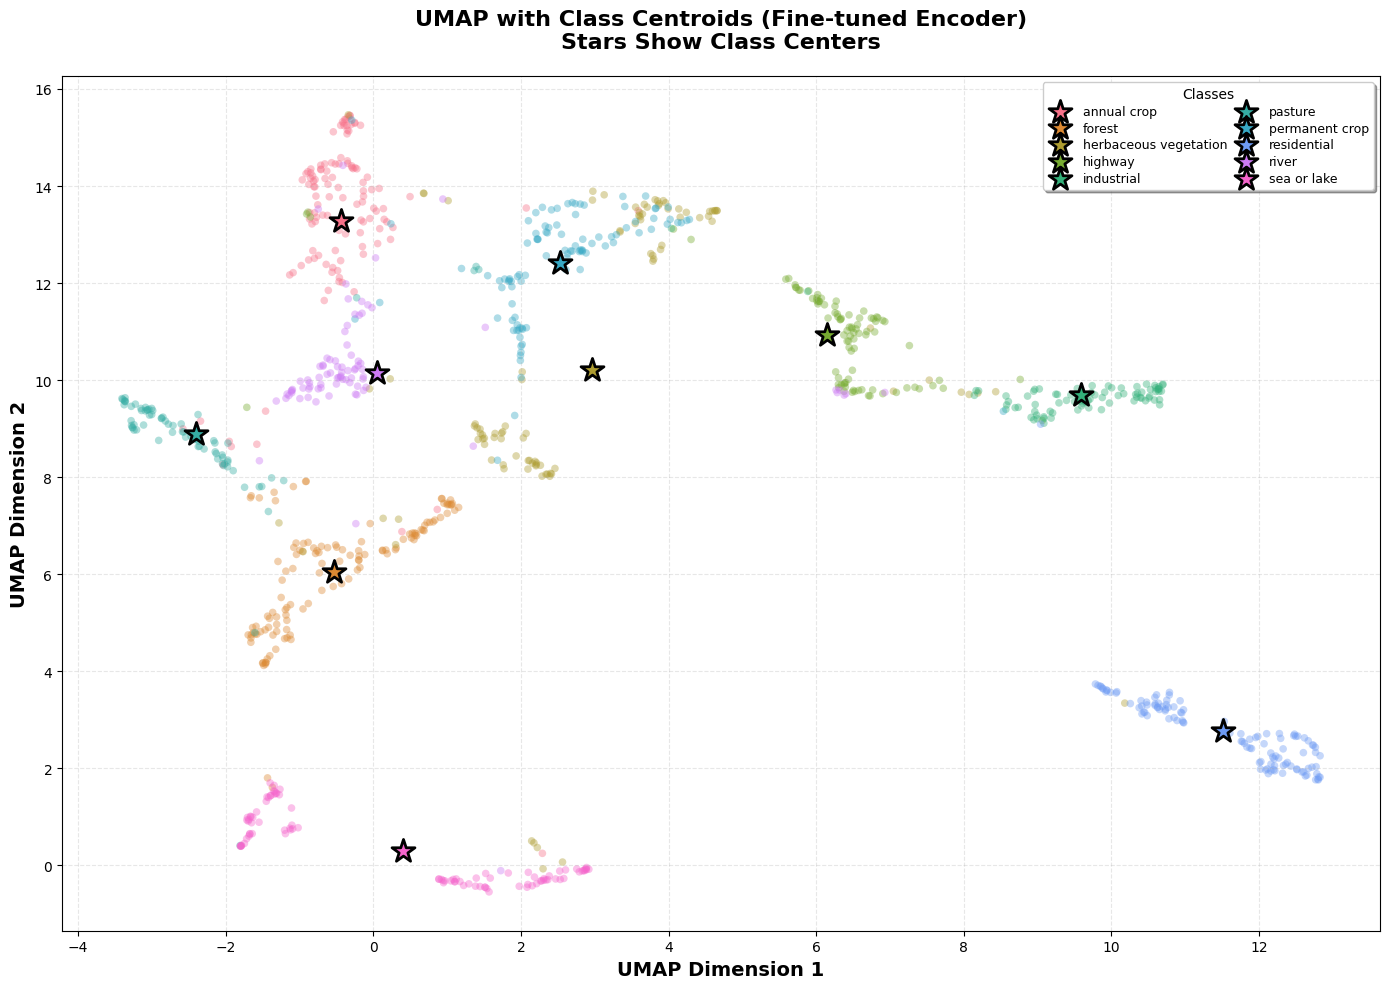


📊 UMAP VISUALIZATION COMPLETE
✅ Visualized 1000 samples across 10 classes
✅ Original embedding dimension: 256
✅ Reduced to 2D using UMAP
✅ Figures saved to: umap_visualizations/

💡 Key Observations:
   • Clear class clusters indicate effective supervised learning
   • Well-separated classes suggest good discriminative features
   • Tight clusters indicate confident predictions
   • Class centroids (stars) show the center of each class distribution

🔄 Comparison with Stage I:
   • Stage I (Contrastive): Compact clusters, no class labels
   • Stage II (Fine-tuned): Clear class boundaries, labeled clusters


In [33]:
# =============================================================================
# 🎨 UMAP Visualization of Fine-tuned Encoder (Stage II)
# =============================================================================
# This visualization shows how class boundaries form after supervised fine-tuning
# We'll extract embeddings from the fine-tuned encoder and visualize them by class

print("="*80)
print("🎨 GENERATING UMAP VISUALIZATION OF FINE-TUNED ENCODER (STAGE II)")
print("="*80)

# Install UMAP if not already installed
try:
    import umap
    print("✅ UMAP already installed")
except ImportError:
    print("📦 Installing UMAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn'])
    import umap
    print("✅ UMAP installed successfully")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import os
from datetime import datetime

# Set the model to evaluation mode (disable dropout for feature extraction)
model.eval()

# ---------------------------------------------------------
# Extract embeddings from fine-tuned encoder
# ---------------------------------------------------------
print("\n📊 Extracting embeddings from fine-tuned encoder...")

# Use validation dataset for cleaner visualization (already has labels 0 to n_classes-1)
# We'll sample from it to keep visualization manageable
num_samples = min(1000, len(val_dataset))  # Use up to 1000 samples
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

# Create subset dataset
from torch.utils.data import Subset
subset_dataset = Subset(val_dataset, sample_indices)

# Create DataLoader
viz_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False, num_workers=2)

embeddings_list = []
labels_list = []

with torch.no_grad():
    for batch in tqdm(viz_loader, desc="Extracting embeddings"):
        images, labels = batch
        images = images.to(device)
        
        # Extract features from the encoder (before classifier)
        features = model.encoder(images)
        
        embeddings_list.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

# Concatenate all embeddings and labels
embeddings = np.vstack(embeddings_list)
labels = np.concatenate(labels_list)

print(f"✅ Extracted embeddings shape: {embeddings.shape}")
print(f"✅ Labels shape: {labels.shape}")
print(f"✅ Unique classes: {len(np.unique(labels))}")

# ---------------------------------------------------------
# Perform UMAP dimensionality reduction
# ---------------------------------------------------------
print("\n🔍 Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

embedding_2d = reducer.fit_transform(embeddings)
print(f"✅ UMAP embedding shape: {embedding_2d.shape}")

# Create output directory for figures
output_dir = "umap_visualizations"
os.makedirs(output_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# ---------------------------------------------------------
# Visualize the UMAP embeddings by class
# ---------------------------------------------------------
print("\n🎨 Creating UMAP visualization with class labels...")

fig, ax = plt.subplots(figsize=(14, 10))

# Create color palette for classes
n_classes = len(ID_CLASS_NAMES)
colors = sns.color_palette("husl", n_classes)

# Plot each class separately for better legend
for class_idx, class_name in enumerate(ID_CLASS_NAMES):
    mask = labels == class_idx
    if np.sum(mask) > 0:
        ax.scatter(
            embedding_2d[mask, 0], 
            embedding_2d[mask, 1],
            c=[colors[class_idx]],
            label=class_name,
            s=50,
            alpha=0.7,
            edgecolors='white',
            linewidth=0.5
        )

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP Visualization of Fine-tuned Encoder (Stage II)\nClass Boundaries After Supervised Training', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Move legend inside the plot area (upper right corner)
ax.legend(loc='upper right', fontsize=9, 
          frameon=True, shadow=True, title='Classes', title_fontsize=10,
          ncol=2, columnspacing=0.5, labelspacing=0.3)

# Add statistics box
textstr = f'Total Samples: {len(labels)}\n'
textstr += f'Embedding Dim: {embeddings.shape[1]}\n'
textstr += f'Classes: {n_classes}\n'
textstr += f'Val Accuracy: {val_accs[-1]:.2f}%'

props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()

# Save the figure
fig_path = os.path.join(output_dir, f"umap_class_boundaries_{timestamp}.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved figure to: {fig_path}")

plt.show()

# ---------------------------------------------------------
# Create a second visualization showing class centroids
# ---------------------------------------------------------
print("\n🎨 Creating visualization with class centroids...")

fig, ax = plt.subplots(figsize=(14, 10))

# Plot points with reduced alpha
for class_idx, class_name in enumerate(ID_CLASS_NAMES):
    mask = labels == class_idx
    if np.sum(mask) > 0:
        # Plot points
        ax.scatter(
            embedding_2d[mask, 0], 
            embedding_2d[mask, 1],
            c=[colors[class_idx]],
            s=30,
            alpha=0.4,
            edgecolors='none'
        )
        
        # Calculate and plot centroid
        centroid = embedding_2d[mask].mean(axis=0)
        ax.scatter(
            centroid[0], 
            centroid[1],
            c=[colors[class_idx]],
            s=300,
            alpha=1.0,
            edgecolors='black',
            linewidth=2,
            marker='*',
            label=class_name,
            zorder=100
        )

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP with Class Centroids (Fine-tuned Encoder)\nStars Show Class Centers', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Move legend inside the plot area (upper right corner)
ax.legend(loc='upper right', fontsize=9, 
          frameon=True, shadow=True, title='Classes', title_fontsize=10,
          ncol=2, columnspacing=0.5, labelspacing=0.3)

plt.tight_layout()

# Save the figure
fig_path2 = os.path.join(output_dir, f"umap_class_centroids_{timestamp}.png")
plt.savefig(fig_path2, dpi=300, bbox_inches='tight')
print(f"💾 Saved figure to: {fig_path2}")

plt.show()

# ---------------------------------------------------------
# Compute and display clustering metrics
# ---------------------------------------------------------
print("\n" + "="*80)
print("📊 UMAP VISUALIZATION COMPLETE")

print("="*80)
print(f"✅ Visualized {len(labels)} samples across {n_classes} classes")
print(f"✅ Original embedding dimension: {embeddings.shape[1]}")
print(f"✅ Reduced to 2D using UMAP")
print(f"✅ Figures saved to: {output_dir}/")
print("\n💡 Key Observations:")
print("   • Clear class clusters indicate effective supervised learning")
print("   • Well-separated classes suggest good discriminative features")
print("   • Tight clusters indicate confident predictions")
print("   • Class centroids (stars) show the center of each class distribution")
print("\n🔄 Comparison with Stage I:")
print("   • Stage I (Contrastive): Compact clusters, no class labels")
print("   • Stage II (Fine-tuned): Clear class boundaries, labeled clusters")
print("="*80)